# TFG

## Instalación e importaciones de librerías

In [1]:
%pip install batchgenerators
%pip install segmentation-models-pytorch
%pip install torchmetrics
%pip install seaborn
%pip install torch torchvision torchaudio


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importación de librerías: DICOM, numpy, matplotlib y widgets interactivos
from pydicom import dcmread
import numpy as np
from pydicom.fileset import FileSet
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
from collections import defaultdict
import pandas as pd
import seaborn as sns
import os

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import pydicom
from pydicom.filereader import dcmread
from pydicom.errors import InvalidDicomError

from torchvision.transforms.functional import resize
from skimage.transform import resize  # Para redimensionar las imágenes
from PIL import Image

import random
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

import re #para expresiones regulares


## Visualización 3D

In [4]:
# Función para visualizar las slices: 
# visualizador 2D con slider para explorar las slices axiales (eje Z)
def plot_slices(volume, patient_name, patient_id, patient_folder):
    # Crear figura y eje
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)

    # Slice inicial
    initial_slice = volume.shape[2] // 2
    slice_view = ax.imshow(volume[:, :, initial_slice], cmap="gray")
    
    # Título con el nombre, ID y carpeta del paciente
    ax.set_title(f"Paciente: {patient_name} (ID: {patient_id})\nCarpeta: {patient_folder} (Axial View)")

    # Slider para explorar las slices
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor="lightgoldenrodyellow")
    slider = Slider(ax_slider, "Slice", 0, volume.shape[2] - 1, valinit=initial_slice, valstep=1)

    # Función para actualizar la slice mostrada
    def update(val):
        slice_idx = int(slider.val)
        slice_view.set_data(volume[:, :, slice_idx])
        fig.canvas.draw_idle()

    slider.on_changed(update)

    # Mostrar la ventana
    plt.show()


In [5]:
# Función para dibujar las slices en cualquier eje
def plot_3d_slices(volume):
    # Initialize the figure and axis
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)

    # Default axis and slice index
    current_axis = 2  # 0 for axial, 1 for coronal, 2 for sagittal
    initial_slice = volume.shape[current_axis] // 2

    # Display the initial slice along the default axis (axial view)
    slice_view = ax.imshow(volume[:, :, initial_slice], cmap="gray")
    ax.set_title("Axial View (Z-Axis)")

    # Create slider to navigate slices
    ax_slider = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor="lightgoldenrodyellow")
    slider = Slider(ax_slider, "Slice", 0, volume.shape[current_axis] - 1, valinit=initial_slice, valstep=1)

    # Button axes and buttons for axis selection
    ax_button_axial = plt.axes([0.25, 0.1, 0.1, 0.04])
    ax_button_coronal = plt.axes([0.45, 0.1, 0.1, 0.04])
    ax_button_sagittal = plt.axes([0.65, 0.1, 0.1, 0.04])

    button_axial = Button(ax_button_axial, "Axial")
    button_coronal = Button(ax_button_coronal, "Coronal")
    button_sagittal = Button(ax_button_sagittal, "Sagital")

    # Update function to display the correct slice when slider moves
    def update_slice(val):
        slice_idx = int(slider.val)
        if current_axis == 0:
            slice_view.set_data(volume[slice_idx, :, :])
            ax.set_title("Axial View (Z-Axis)")
        elif current_axis == 1:
            slice_view.set_data(volume[:, slice_idx, :])
            ax.set_title("Coronal View (Y-Axis)")
        elif current_axis == 2:
            slice_view.set_data(volume[:, :, slice_idx])
            ax.set_title("Sagittal View (X-Axis)")
        fig.canvas.draw_idle()

    # Function to reset slider when switching between views
    def reset_slider(axis):
        nonlocal current_axis
        current_axis = axis
        slider.valmin = 0
        slider.valmax = volume.shape[current_axis] - 1
        slider.set_val(volume.shape[current_axis] // 2)  # Reset slider to middle slice
        slider.ax.set_xlim(slider.valmin, slider.valmax)  # Update slider range
        update_slice(slider.val)

    # Functions to switch between axial, coronal, and sagittal views
    def set_axial(event):
        reset_slider(0)

    def set_coronal(event):
        reset_slider(1)

    def set_sagittal(event):
        reset_slider(2)

    # Connect buttons to their functions
    button_axial.on_clicked(set_axial)
    button_coronal.on_clicked(set_coronal)
    button_sagittal.on_clicked(set_sagittal)

    # Connect slider update to the update_slice function
    slider.on_changed(update_slice)

    # Show the plot
    plt.show()


## Lectura de los datos del Excel

In [2]:
#lectura del csv
train = pd.read_csv("datos_limpios.csv", na_values="NaN", sep = ",") # Definimos na_values para identificar bien los valores perdidos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id_paciente           60 non-null     object
 1   Sexo                  60 non-null     object
 2   Edad                  60 non-null     int64 
 3   Tipo de cáncer        60 non-null     object
 4   Complicación          60 non-null     object
 5   Tipo de complicación  60 non-null     object
 6   Factor de riesgo      60 non-null     object
 7   Patología pulmonar    60 non-null     object
 8   TC                    59 non-null     object
 9   Mutación              59 non-null     object
dtypes: int64(1), object(9)
memory usage: 4.8+ KB


In [3]:
train

Id_paciente    Sexo  Edad                        Tipo de cáncer  \
0        1MASh   Mujer    77                        Adenocarcinoma   
1        2HENX  Hombre    61                           Epidermoide   
2        3HENX  Hombre    84                           Epidermoide   
3        4HLSh  Hombre    31                    Linfoma de Hodgkin   
4        5HANX  Hombre    62                        Adenocarcinoma   
5        6MASN   Mujer    61                        Adenocarcinoma   
6        7MPNX   Mujer    84                           Epidermoide   
7        8HENX  Hombre    65                           Epidermoide   
8        9MANX   Mujer    38                        Adenocarcinoma   
9       10MANX   Mujer    65                        Adenocarcinoma   
10      11HASh  Hombre    77                        Adenocarcinoma   
11      12HNSN  Hombre    47                 No tumor: posible TBC   
12      13HANX  Hombre    53                        Adenocarcinoma   
13      14MLNX   Mujer    30                             Linfoma T   
14      15MANX   Mujer    87                        Adenocarcinoma   
15      16HLNX  Hombre    77   Linfoma B Difuso de Células Grandes   
16      17MANX   Mujer    60                        Adenocarcinoma   
17      18MANX   Mujer    80                        Adenocarcinoma   
18      19MANX   Mujer    54                        Adenocarcinoma   
19      20MMNX   Mujer    51             Metástasis cáncer de mama   
20     21MMiNX   Mujer    66       Carcinoma microcítico de pulmón   
21      22MTNX   Mujer    59                                Timoma   
22      23MMNX   Mujer    51                           Microcítico   
23      24MANX  Hombre    74                        Adenocarcinoma   
24      25HTNX  Hombre    43                                Timoma   
25      26HMNX  Hombre    67                           Mesotelioma   
26      27HASD  Hombre    82                        Adenocarcinoma   
27     28HCGNX  Hombre    42       Células grandes, Neuroendocrino   
28     29HMeSX  Hombre    76                              Melanoma   
29      30MANX   Mujer    73                        Adenocarcinoma   
30      31MGNX   Mujer    56           Granulomas no caseificantes   
31      32HENX  Hombre    71                 Carcinoma epidermoide   
32      33MANX   Mujer    48                        Adenocarcinoma   
33      34MASN   Mujer    63                        Adenocarcinoma   
34      35HENX  Hombre    73                 Carcinoma epidermoide   
35      36HENX  Hombre    81                 Carcinoma epidermoide   
36      37HPNX  Hombre    42          Pleuritis crónica fibrosante   
37      38HANX  Hombre    60                        Adenocarcinoma   
38      39MFNX   Mujer    58       Tumor fibroso solitario benigno   
39      40HANX  Hombre    81                        Adenocarcinoma   
40     41HAsNX  Hombre    80                          Aspergilosis   
41     42HNnNX  Hombre    55                          No neoplasia   
42      43HESH  Hombre    77                    Cáncer Epidermoide   
43     44MTmNX   Mujer    77                     Tumor mesenquimal   
44     45HNeSN  Hombre    76                         Neumoconiosis   
45      46HANX  Hombre    63                        Adenocarcinoma   
46      47HESN  Hombre    70                    Cáncer Epidermoide   
47     48HTtSN  Hombre    18                         Tejido Tímico   
48     49MMiSN   Mujer    82       Carcinoma microcítico de pulmón   
49      50HANX  Hombre    72                        Adenocarcinoma   
50      51HFNX  Hombre    77      Fibrosis parenquimatosa pulmonar   
51      52HLNX  Hombre    56                          Linfoma MALT   
52      53HANX  Hombre    76                        Adenocarcinoma   
53      54HANX  Hombre    62                        Adenocarcinoma   
54      55HASN  Hombre    56                        Adenocarcinoma   
55      56MANX   Mujer    54                        Adenocarcinoma   
56    57HTneN

In [ ]:
#Vamos a borrar los dos pacientes que me dan error: el 14 y el 49
#elimino las anteriores porque los pacientes empiezan en 1 y la lista en 0
train = train.drop([13, 19, 20, 43, 48])

# Verificar que las filas han sido eliminadas
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id_paciente           55 non-null     object
 1   Sexo                  55 non-null     object
 2   Edad                  55 non-null     int64 
 3   Tipo de cáncer        55 non-null     object
 4   Complicación          55 non-null     object
 5   Tipo de complicación  55 non-null     object
 6   Factor de riesgo      55 non-null     object
 7   Patología pulmonar    55 non-null     object
 8   TC                    54 non-null     object
 9   Mutación              54 non-null     object
dtypes: int64(1), object(9)
memory usage: 4.7+ KB


In [5]:
train

Id_paciente    Sexo  Edad                        Tipo de cáncer  \
0        1MASh   Mujer    77                        Adenocarcinoma   
1        2HENX  Hombre    61                           Epidermoide   
2        3HENX  Hombre    84                           Epidermoide   
3        4HLSh  Hombre    31                    Linfoma de Hodgkin   
4        5HANX  Hombre    62                        Adenocarcinoma   
5        6MASN   Mujer    61                        Adenocarcinoma   
6        7MPNX   Mujer    84                           Epidermoide   
7        8HENX  Hombre    65                           Epidermoide   
8        9MANX   Mujer    38                        Adenocarcinoma   
9       10MANX   Mujer    65                        Adenocarcinoma   
10      11HASh  Hombre    77                        Adenocarcinoma   
11      12HNSN  Hombre    47                 No tumor: posible TBC   
12      13HANX  Hombre    53                        Adenocarcinoma   
14      15MANX   Mujer    87                        Adenocarcinoma   
15      16HLNX  Hombre    77   Linfoma B Difuso de Células Grandes   
16      17MANX   Mujer    60                        Adenocarcinoma   
17      18MANX   Mujer    80                        Adenocarcinoma   
18      19MANX   Mujer    54                        Adenocarcinoma   
21      22MTNX   Mujer    59                                Timoma   
22      23MMNX   Mujer    51                           Microcítico   
23      24MANX  Hombre    74                        Adenocarcinoma   
24      25HTNX  Hombre    43                                Timoma   
25      26HMNX  Hombre    67                           Mesotelioma   
26      27HASD  Hombre    82                        Adenocarcinoma   
27     28HCGNX  Hombre    42       Células grandes, Neuroendocrino   
28     29HMeSX  Hombre    76                              Melanoma   
29      30MANX   Mujer    73                        Adenocarcinoma   
30      31MGNX   Mujer    56           Granulomas no caseificantes   
31      32HENX  Hombre    71                 Carcinoma epidermoide   
32      33MANX   Mujer    48                        Adenocarcinoma   
33      34MASN   Mujer    63                        Adenocarcinoma   
34      35HENX  Hombre    73                 Carcinoma epidermoide   
35      36HENX  Hombre    81                 Carcinoma epidermoide   
36      37HPNX  Hombre    42          Pleuritis crónica fibrosante   
37      38HANX  Hombre    60                        Adenocarcinoma   
38      39MFNX   Mujer    58       Tumor fibroso solitario benigno   
39      40HANX  Hombre    81                        Adenocarcinoma   
40     41HAsNX  Hombre    80                          Aspergilosis   
41     42HNnNX  Hombre    55                          No neoplasia   
42      43HESH  Hombre    77                    Cáncer Epidermoide   
44     45HNeSN  Hombre    76                         Neumoconiosis   
45      46HANX  Hombre    63                        Adenocarcinoma   
46      47HESN  Hombre    70                    Cáncer Epidermoide   
47     48HTtSN  Hombre    18                         Tejido Tímico   
49      50HANX  Hombre    72                        Adenocarcinoma   
50      51HFNX  Hombre    77      Fibrosis parenquimatosa pulmonar   
51      52HLNX  Hombre    56                          Linfoma MALT   
52      53HANX  Hombre    76                        Adenocarcinoma   
53      54HANX  Hombre    62                        Adenocarcinoma   
54      55HASN  Hombre    56                        Adenocarcinoma   
55      56MANX   Mujer    54                        Adenocarcinoma   
56    57HTneNX  Hombre    72  Tumor Neuroendocrino de céula grande   
57      58MASH   Mujer    76                        Adenocarcinoma   
58     59MMiNX   Mujer    66       Carcinoma microcítico de pulmón   
59      60HESN  Hombre    80                    Cáncer Epidermoide   

   Complicación     Tipo de complicación  \
0            Sí          Hemorragia le

In [9]:
#atributos
train.columns

Index(['Id_paciente', 'Sexo', 'Edad', 'Tipo de cáncer', 'Complicación',
       'Tipo de complicación', 'Factor de riesgo', 'Patología pulmonar', 'TC',
       'Mutación'],
      dtype='object')

Vamos a asociar el id_paciente con si tiene complicación o no y después podremos asociarlo a la imagen con el mismo id_paciente.

In [5]:
# Mostrar los valores únicos de la columna "Complicación" y contar cuántos hay de cada clase
complicacion_counts = train['Complicación'].value_counts()
print("Valores únicos en 'Complicación':")
print(complicacion_counts)

Valores únicos en 'Complicación':
Complicación
No    40
Sí    15
Name: count, dtype: int64


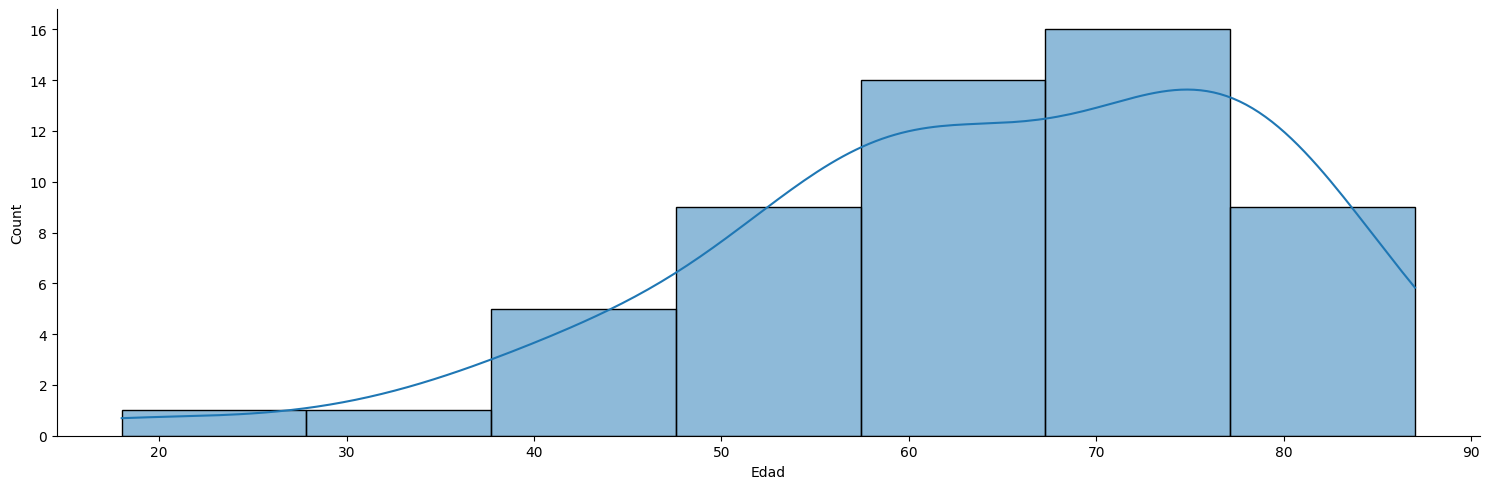

In [12]:
#visualizo la edad de los pacientes
sns.displot(data=train, x="Edad", aspect=3, kde=True)

Vemos las posibles clases de cada columna

In [13]:
# Obtener valores únicos de cada columna
for columna in train.columns:
    print(f"Columna: {columna}")
    print(train[columna].unique())  # Valores únicos
    print("-" * 50)  # Separador para imprimir

Columna: Id_paciente
['1MASh' '2HENX' '3HENX' '4HLSh' '5HANX' '6MASN' '7MPNX' '8HENX' '9MANX'
 '10MANX' '11HASh' '12HNSN' '13HANX' '15MANX' '16HLNX' '17MANX' '18MANX'
 '19MANX' '22MTNX' '23MMNX' '24MANX' '25HTNX' '26HMNX' '27HASD' '28HCGNX'
 '29HMeSX' '30MANX' '31MGNX' '32HENX' '33MANX' '34MASN' '35HENX' '36HENX'
 '37HPNX' '38HANX' '39MFNX' '40HANX' '41HAsNX' '42HNnNX' '43HESH'
 '45HNeSN' '46HANX' '47HESN' '48HTtSN' '50HANX' '51HFNX' '52HLNX' '53HANX'
 '54HANX' '55HASN' '56MANX' '57HTneNX' '58MASH' '59MMiNX' '60HESN']
--------------------------------------------------
Columna: Sexo
['Mujer' 'Hombre']
--------------------------------------------------
Columna: Edad
[77 61 84 31 62 65 38 47 53 87 60 80 54 59 51 74 43 67 82 42 76 73 56 71
 48 63 81 58 55 70 18 72 66]
--------------------------------------------------
Columna: Tipo de cáncer
['Adenocarcinoma' 'Epidermoide' 'Linfoma de Hodgkin'
 'No tumor: posible TBC' 'Linfoma B Difuso de Células Grandes' 'Timoma'
 'Microcítico' 'Mesotelio

Verifcamos los datos perdidos

In [14]:
# Verificar valores perdidos
valores_perdidos = train.isnull().sum()
print("Valores perdidos por columna:")
print(valores_perdidos)

Valores perdidos por columna:
Id_paciente             0
Sexo                    0
Edad                    0
Tipo de cáncer          0
Complicación            0
Tipo de complicación    0
Factor de riesgo        0
Patología pulmonar      0
TC                      1
Mutación                1
dtype: int64


## Definición de carpetas y particiones (común)

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Crear un diccionario que mapee Id_paciente a Complicación
labels_dict = dict(zip(train['Id_paciente'], train['Complicación']))
labels_dict

{'1MASh': 'Sí',
 '2HENX': 'No',
 '3HENX': 'No',
 '4HLSh': 'Sí',
 '5HANX': 'No',
 '6MASN': 'Sí',
 '7MPNX': 'No',
 '8HENX': 'No',
 '9MANX': 'No',
 '10MANX': 'No',
 '11HASh': 'Sí',
 '12HNSN': 'Sí',
 '13HANX': 'No',
 '15MANX': 'No',
 '16HLNX': 'No',
 '17MANX': 'No',
 '18MANX': 'No',
 '19MANX': 'No',
 '22MTNX': 'No',
 '23MMNX': 'No',
 '24MANX': 'No',
 '25HTNX': 'No',
 '26HMNX': 'No',
 '27HASD': 'Sí',
 '28HCGNX': 'No',
 '29HMeSX': 'Sí',
 '30MANX': 'No',
 '31MGNX': 'No',
 '32HENX': 'No',
 '33MANX': 'No',
 '34MASN': 'Sí',
 '35HENX': 'No',
 '36HENX': 'No',
 '37HPNX': 'No',
 '38HANX': 'No',
 '39MFNX': 'No',
 '40HANX': 'No',
 '41HAsNX': 'No',
 '42HNnNX': 'No',
 '43HESH': 'Sí',
 '45HNeSN': 'Sí',
 '46HANX': 'No',
 '47HESN': 'Sí',
 '48HTtSN': 'Sí',
 '50HANX': 'No',
 '51HFNX': 'No',
 '52HLNX': 'No',
 '53HANX': 'No',
 '54HANX': 'No',
 '55HASN': 'Sí',
 '56MANX': 'No',
 '57HTneNX': 'No',
 '58MASH': 'Sí',
 '59MMiNX': 'No',
 '60HESN': 'Sí'}

In [12]:
#DATOS GENERALES
root_path_antigua= "./datosprueba/casosradiomica/"  # Directorio raíz que contiene los pacientes
patient_dirs = [os.path.join(root_path_antigua, d) for d in os.listdir(root_path_antigua) if os.path.isdir(os.path.join(root_path_antigua, d))]


In [9]:
#DATOS ANONIMIZADOS
root_path = "./datos_anonimizados/"  # Directorio raíz que contiene los pacientes
patient_dirs = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]


In [10]:
#Particiones
""" 
- TRAINING: CASOS [1,50] INCLUIDOS (50 CASOS)
- VALIDATION: CASOS [50, 60] INCLUIDOS (10 CASOS)
- TEST: completar """

# RANGOS DE CASOS
all_cases = [i for i in range(1, 61)]  # Índices de los casos que existen, ahoramismo solo tengo del 1 al 60

train_cases = list(range(1, 50))  # Casos 1-49
val_cases = list(range(50, 60))  # Casos 50-59
test_cases = []  

print("Todos los casos:", all_cases) 
print("Training:", train_cases)
print("Validation:", val_cases)
print("Test:", test_cases)  

Todos los casos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Training: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Validation: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Test: []


## Lectura de imágenes

Procesando Paciente: Anónimo (ID: 10MANX), Carpeta: 10MANX, Volume shape: (768, 768, 292)


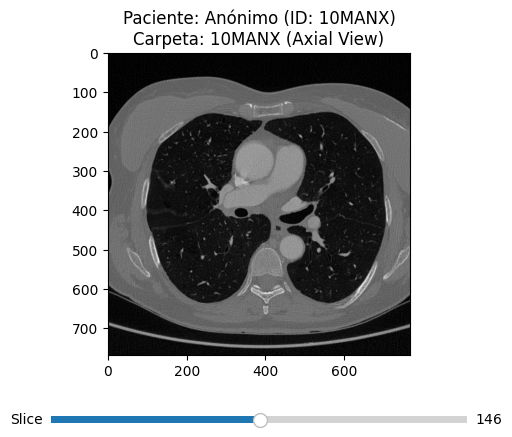

Procesando Paciente: Anónimo (ID: 11HASh), Carpeta: 11HASh, Volume shape: (512, 512, 223)


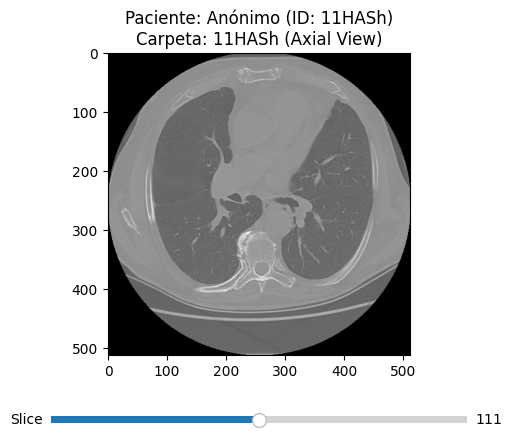

Procesando Paciente: Anónimo (ID: 12HNSN), Carpeta: 12HNSN, Volume shape: (768, 768, 364)


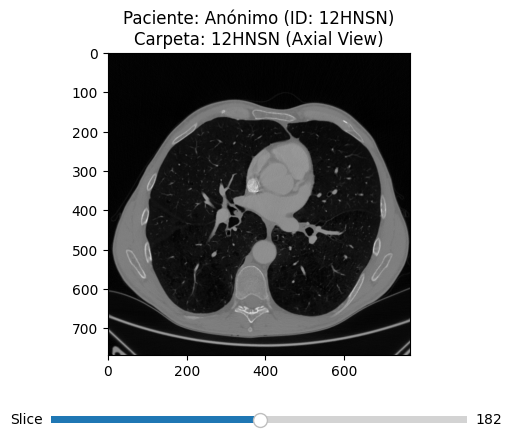

Procesando Paciente: Anónimo (ID: 13HANX), Carpeta: 13HANX, Volume shape: (512, 512, 259)


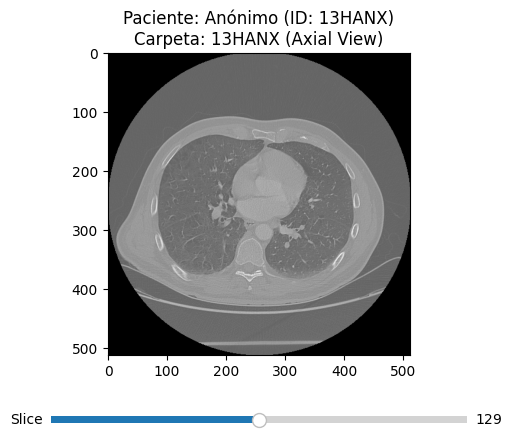

Procesando Paciente: Anónimo (ID: 15MANX), Carpeta: 15MANX, Volume shape: (512, 512, 229)


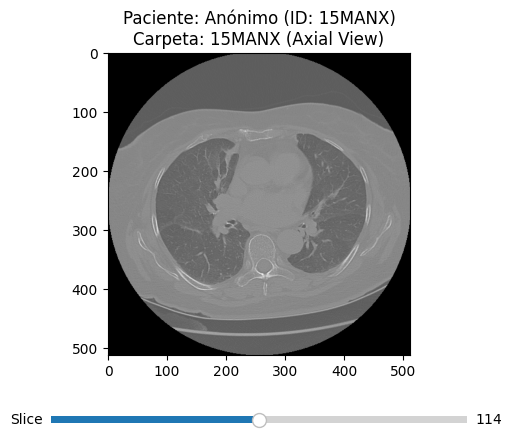

Procesando Paciente: Anónimo (ID: 16HLNX), Carpeta: 16HLNX, Volume shape: (768, 768, 300)


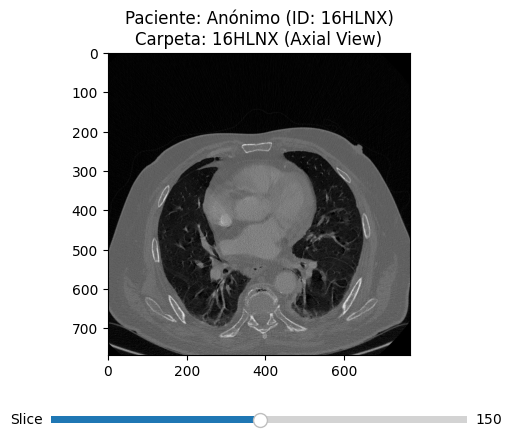

Procesando Paciente: Anónimo (ID: 17MANX), Carpeta: 17MANX, Volume shape: (512, 512, 220)


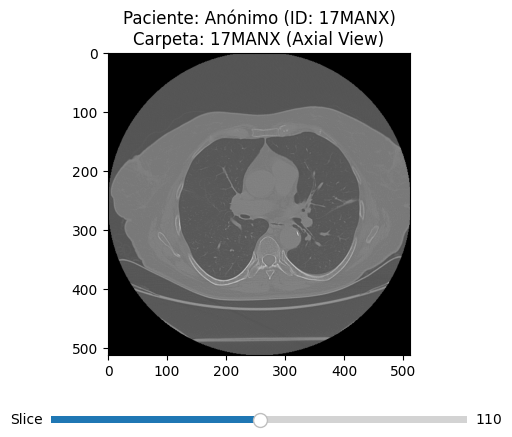

Procesando Paciente: Anónimo (ID: 18MANX), Carpeta: 18MANX, Volume shape: (512, 512, 215)


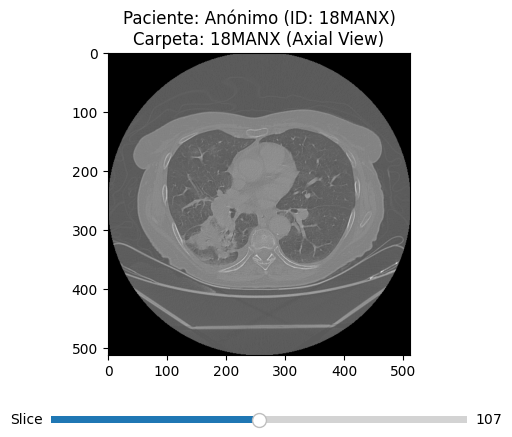

Procesando Paciente: Anónimo (ID: 19MANX), Carpeta: 19MANX, Volume shape: (512, 512, 67)


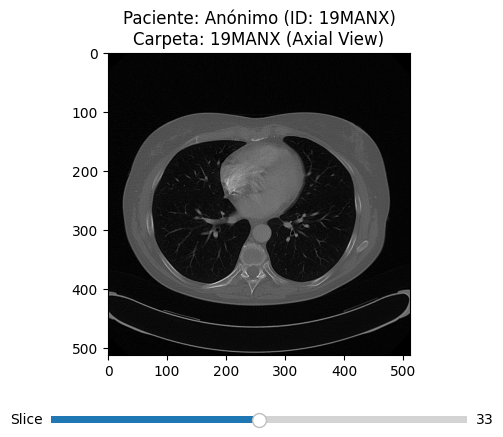

Procesando Paciente: Anónimo (ID: 1MASh), Carpeta: 1MASh, Volume shape: (768, 768, 271)


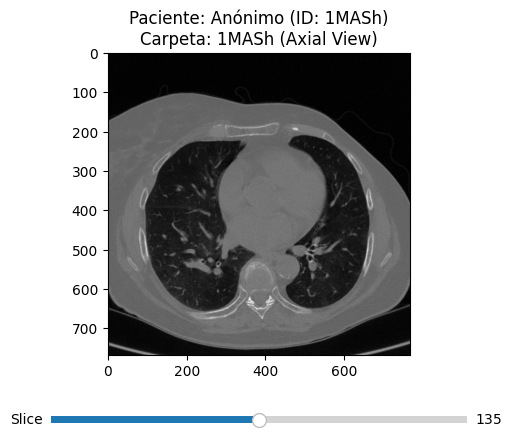

Procesando Paciente: Anónimo (ID: 22MTNX), Carpeta: 22MTNX, Volume shape: (768, 768, 545)


Procesando Paciente: Anónimo (ID: 23MMNX), Carpeta: 23MMNX, Volume shape: (512, 512, 231)


Procesando Paciente: Anónimo (ID: 24MANX), Carpeta: 24MANX, Volume shape: (768, 768, 54)


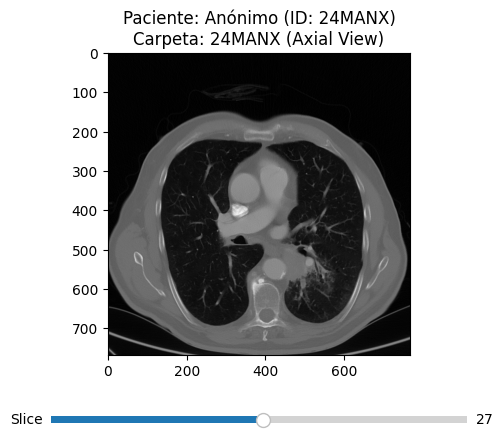

Procesando Paciente: Anónimo (ID: 25HTNX), Carpeta: 25HTNX, Volume shape: (512, 512, 208)


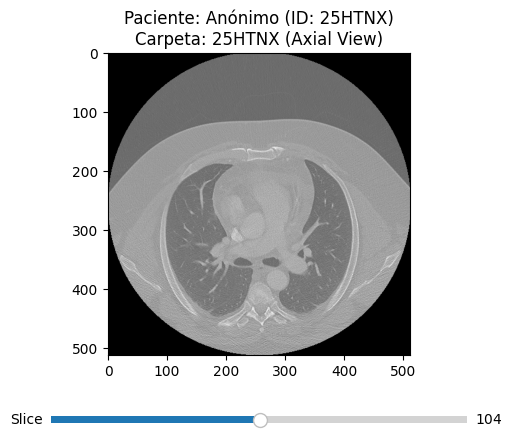

Procesando Paciente: Anónimo (ID: 26HMNX), Carpeta: 26HMNX, Volume shape: (768, 768, 301)


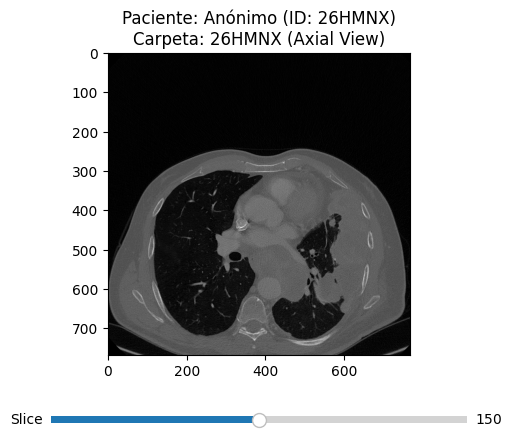

Procesando Paciente: Anónimo (ID: 27HASD), Carpeta: 27HASD, Volume shape: (768, 768, 291)


Procesando Paciente: Anónimo (ID: 28HCGNX), Carpeta: 28HCGNX, Volume shape: (768, 768, 327)


Procesando Paciente: Anónimo (ID: 29HMeSX), Carpeta: 29HMeSX, Volume shape: (768, 768, 2)


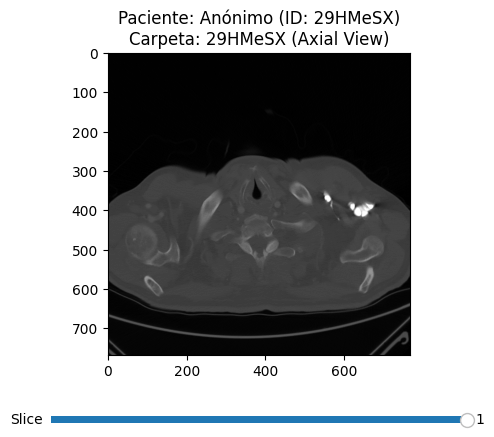

Procesando Paciente: Anónimo (ID: 2HENX), Carpeta: 2HENX, Volume shape: (768, 768, 296)


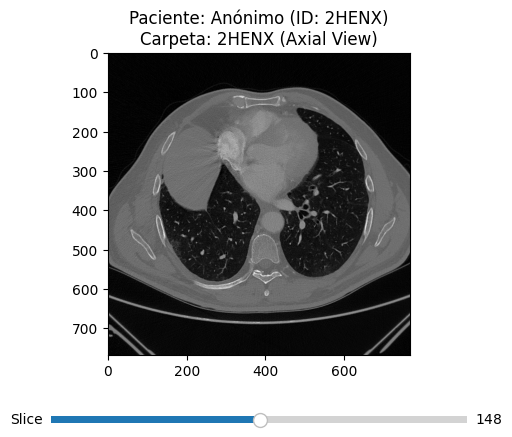

Procesando Paciente: Anónimo (ID: 30MANX), Carpeta: 30MANX, Volume shape: (768, 768, 2)


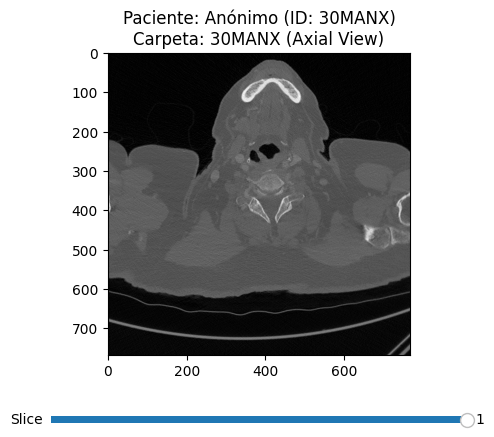

Procesando Paciente: Anónimo (ID: 31MGNX), Carpeta: 31MGNX, Volume shape: (512, 512, 463)


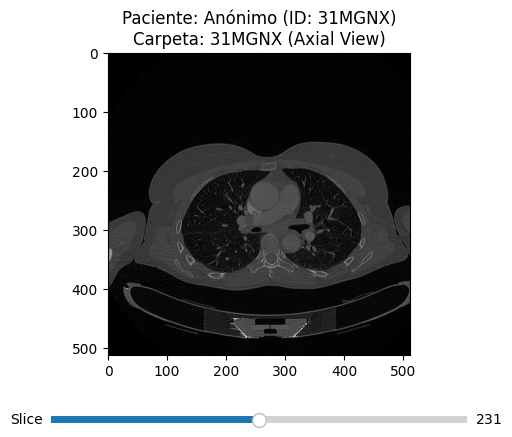

Procesando Paciente: Anónimo (ID: 32HENX), Carpeta: 32HENX, Volume shape: (512, 512, 328)


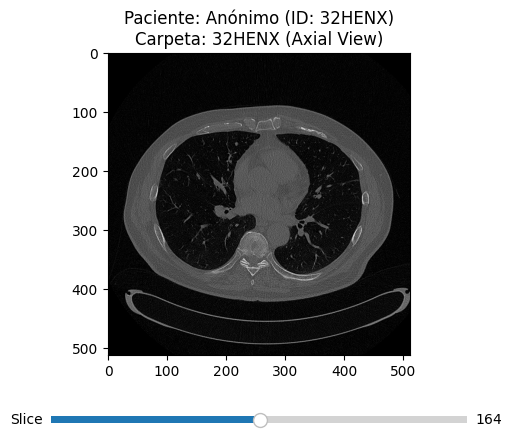

Procesando Paciente: Anónimo (ID: 33MANX), Carpeta: 33MANX, Volume shape: (768, 768, 609)


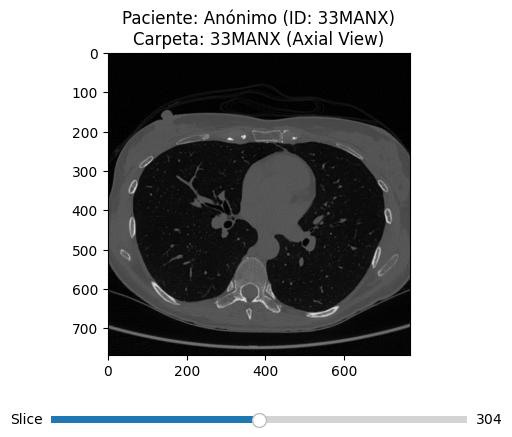

Procesando Paciente: Anónimo (ID: 34MASN), Carpeta: 34MASN, Volume shape: (512, 512, 222)


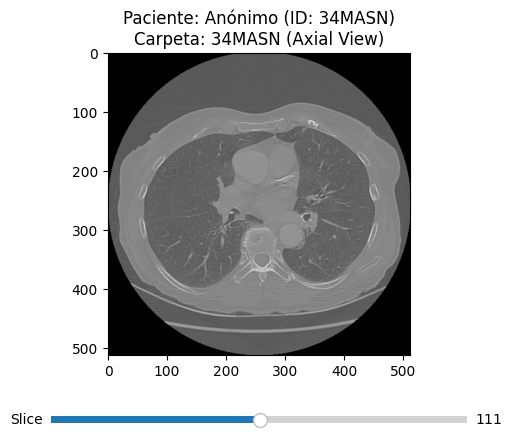

Procesando Paciente: Anónimo (ID: 35HENX), Carpeta: 35HENX, Volume shape: (768, 768, 286)


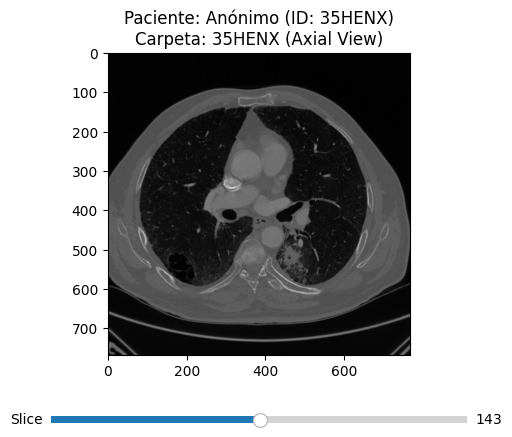

Procesando Paciente: Anónimo (ID: 36HENX), Carpeta: 36HENX, Volume shape: (768, 768, 51)


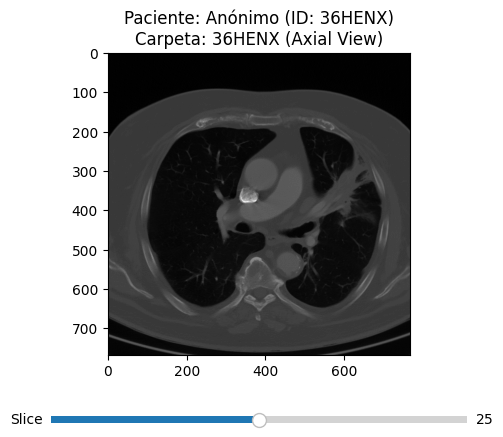

Procesando Paciente: Anónimo (ID: 37HPNX), Carpeta: 37HPNX, Volume shape: (768, 768, 290)


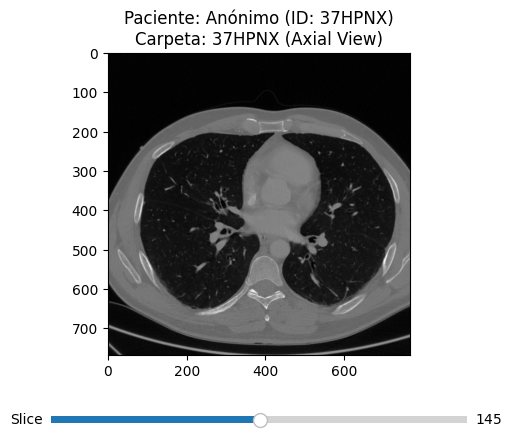

Procesando Paciente: Anónimo (ID: 38HANX), Carpeta: 38HANX, Volume shape: (512, 512, 473)


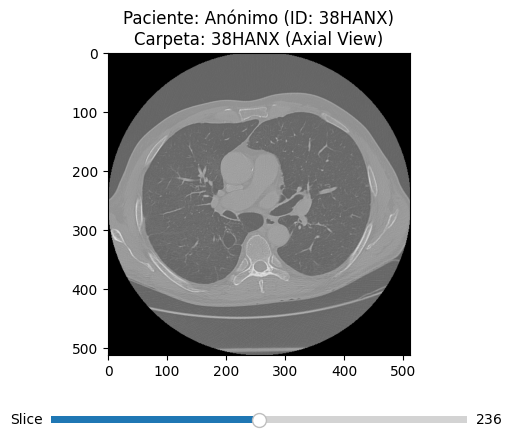

Procesando Paciente: Anónimo (ID: 39MFNX), Carpeta: 39MFNX, Volume shape: (768, 768, 285)


Procesando Paciente: Anónimo (ID: 3HENX), Carpeta: 3HENX, Volume shape: (768, 768, 303)


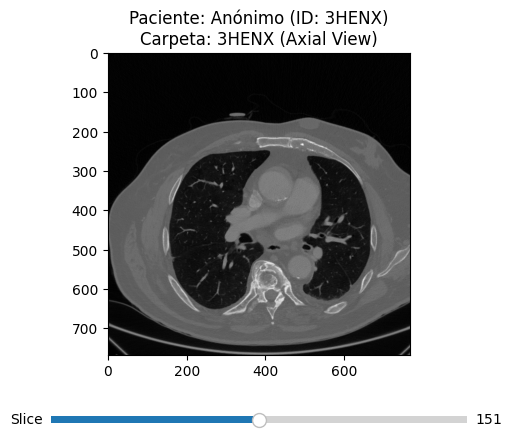

Procesando Paciente: Anónimo (ID: 40HANX), Carpeta: 40HANX, Volume shape: (512, 512, 488)


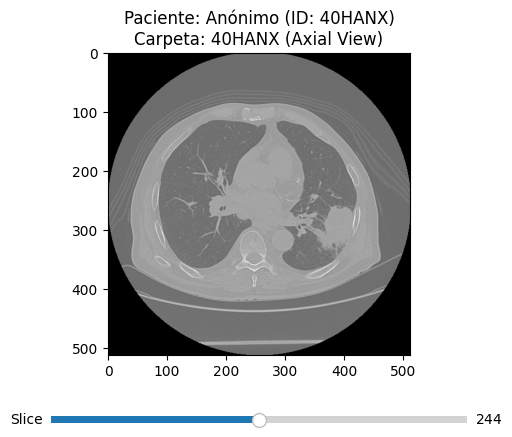

Procesando Paciente: Anónimo (ID: 41HAsNX), Carpeta: 41HAsNX, Volume shape: (512, 512, 174)


Procesando Paciente: Anónimo (ID: 42HNnNX), Carpeta: 42HNnNX, Volume shape: (512, 512, 151)


Procesando Paciente: Anónimo (ID: 43HESH), Carpeta: 43HESH, Volume shape: (512, 512, 225)


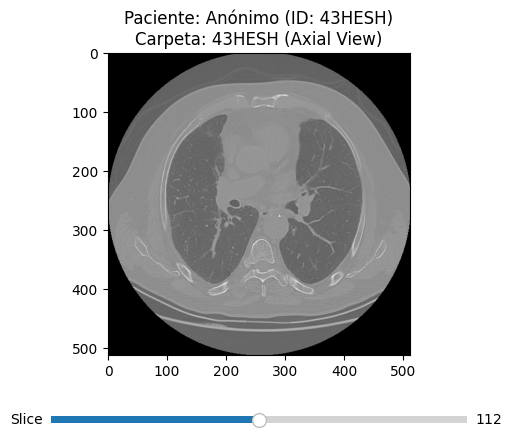

Procesando Paciente: Anónimo (ID: 45HNeSN), Carpeta: 45HNeSN, Volume shape: (768, 768, 285)


Procesando Paciente: Anónimo (ID: 46HANX), Carpeta: 46HANX, Volume shape: (512, 512, 155)


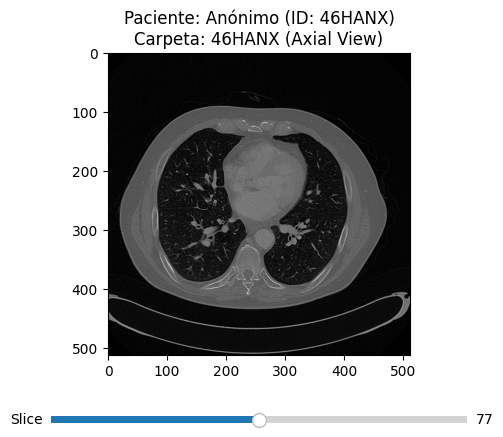

Procesando Paciente: Anónimo (ID: 47HESN), Carpeta: 47HESN, Volume shape: (768, 768, 319)


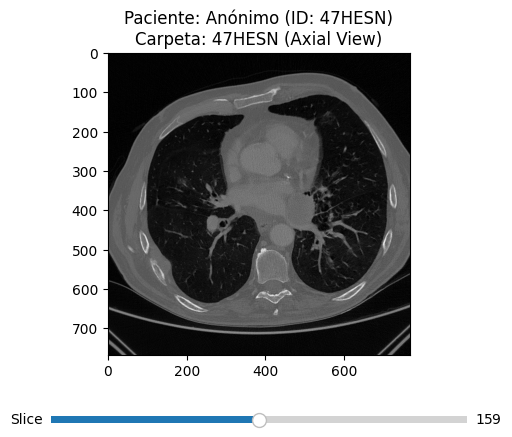

Procesando Paciente: Anónimo (ID: 48HTtSN), Carpeta: 48HTtSN, Volume shape: (512, 512, 155)


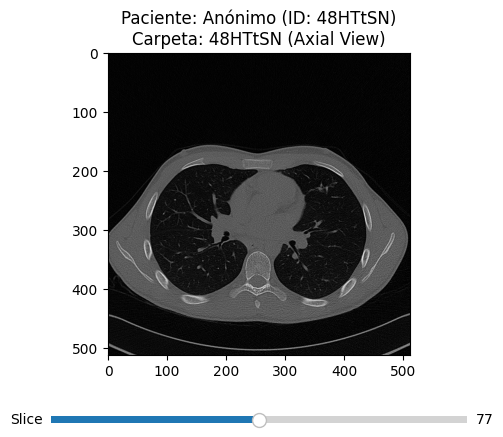

Procesando Paciente: Anónimo (ID: 4HLSh), Carpeta: 4HLSh, Volume shape: (768, 768, 320)


Procesando Paciente: Anónimo (ID: 50HANX), Carpeta: 50HANX, Volume shape: (768, 768, 44)


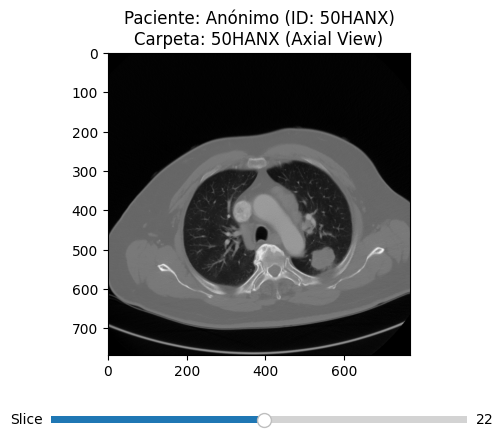

Procesando Paciente: Anónimo (ID: 51HFNX), Carpeta: 51HFNX, Volume shape: (768, 768, 295)


Procesando Paciente: Anónimo (ID: 52HLNX), Carpeta: 52HLNX, Volume shape: (512, 512, 222)


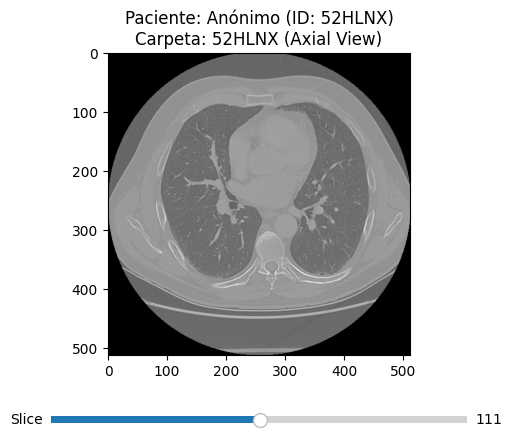

Procesando Paciente: Anónimo (ID: 53HANX), Carpeta: 53HANX, Volume shape: (512, 512, 497)


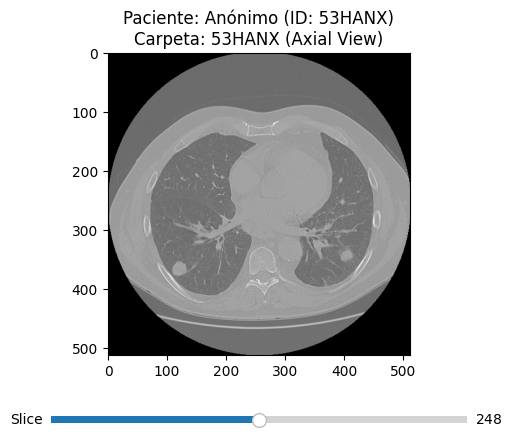

Procesando Paciente: Anónimo (ID: 54HANX), Carpeta: 54HANX, Volume shape: (768, 768, 321)


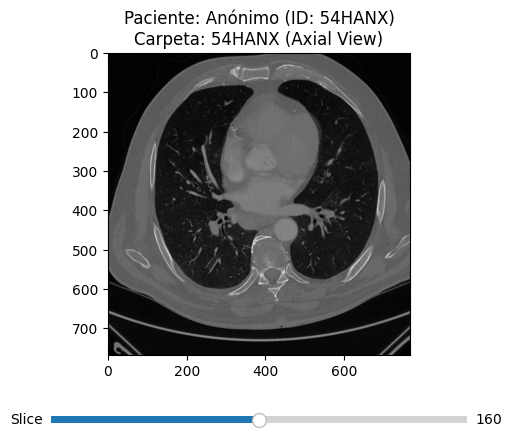

Procesando Paciente: Anónimo (ID: 55HASN), Carpeta: 55HASN, Volume shape: (512, 512, 39)


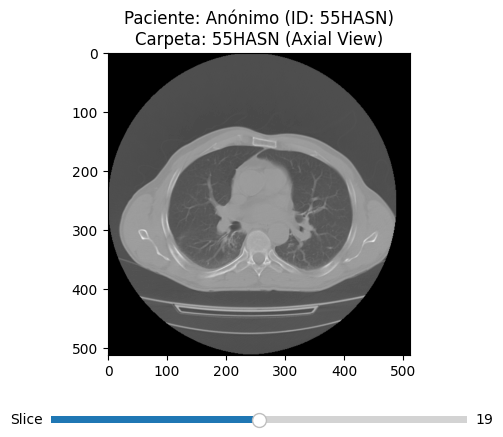

Procesando Paciente: Anónimo (ID: 56MANX), Carpeta: 56MANX, Volume shape: (768, 768, 297)


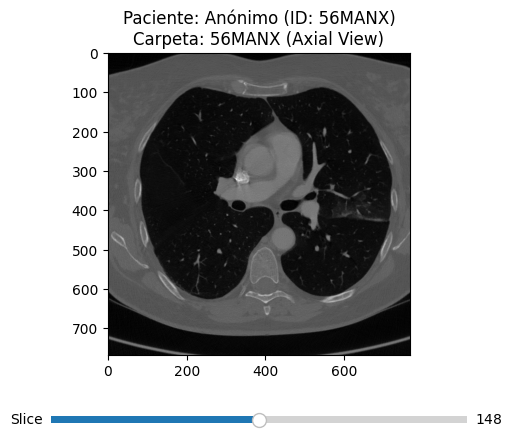

Procesando Paciente: Anónimo (ID: 57HTneNX), Carpeta: 57HTneNX, Volume shape: (512, 512, 317)


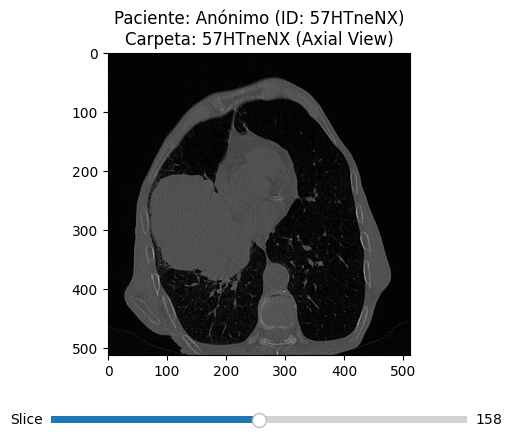

Procesando Paciente: Anónimo (ID: 58MASH), Carpeta: 58MASH, Volume shape: (512, 512, 267)


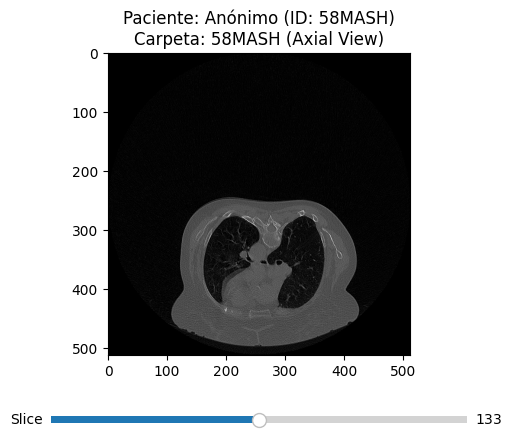

Procesando Paciente: Anónimo (ID: 59MMiNX), Carpeta: 59MMiNX, Volume shape: (512, 512, 146)


Procesando Paciente: Anónimo (ID: 5HANX), Carpeta: 5HANX, Volume shape: (512, 512, 272)


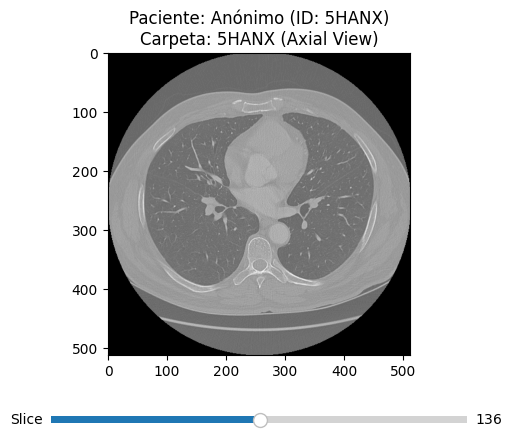

Procesando Paciente: Anónimo (ID: 60HESN), Carpeta: 60HESN, Volume shape: (768, 768, 276)


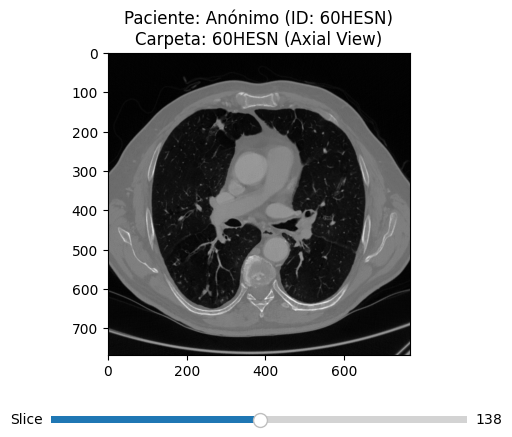

Procesando Paciente: Anónimo (ID: 6MASN), Carpeta: 6MASN, Volume shape: (512, 512, 578)


Procesando Paciente: Anónimo (ID: 7MPNX), Carpeta: 7MPNX, Volume shape: (512, 512, 270)


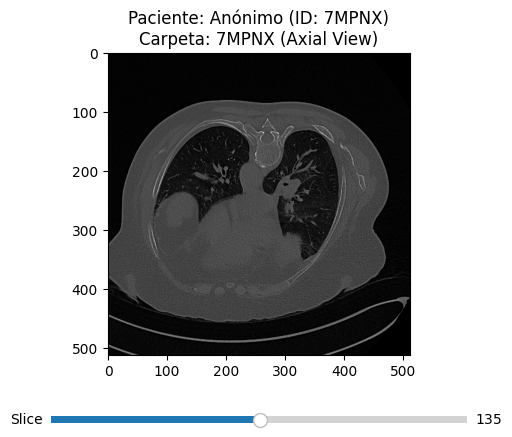

Procesando Paciente: Anónimo (ID: 8HENX), Carpeta: 8HENX, Volume shape: (768, 768, 366)


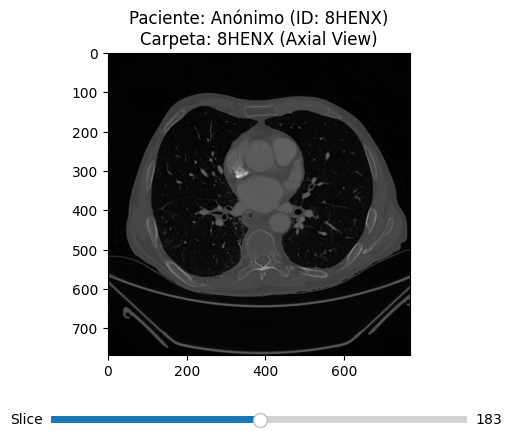

Procesando Paciente: Anónimo (ID: 9MANX), Carpeta: 9MANX, Volume shape: (512, 512, 255)


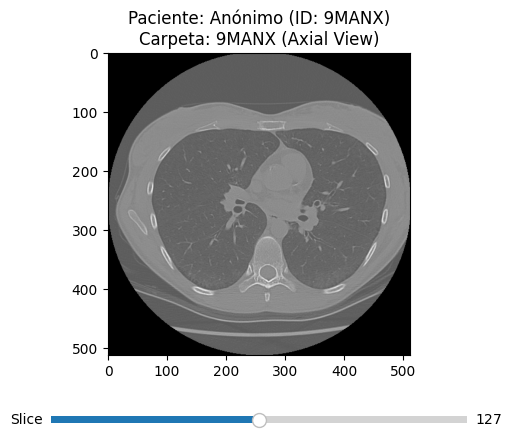

In [13]:
# Lista para almacenar el número de slices por caso
slices_per_case = []

# Iteramos sobre cada carpeta de paciente
for patient_dir in patient_dirs:
    dicom_files = []
    
    # Nombre de la carpeta = ID del paciente
    patient_id = os.path.basename(patient_dir)  # Asignamos el ID de la carpeta al paciente

    # Intentar leer todos los archivos del directorio (sin importar la extensión)
    for filename in os.listdir(patient_dir):
        filepath = os.path.join(patient_dir, filename)
        try:
            # Intentar leer el archivo como DICOM
            ds = dcmread(filepath, force=True)  # force=True permite leer aunque no tenga extensión .dcm (nosotros tenemos dicom pero no tenemos la extension esa)
            dicom_files.append(ds)
        except:
            continue  # Si falla, no es un archivo DICOM válido

    if not dicom_files:
        print(f"No se encontraron archivos DICOM en {patient_dir}. Se omite.")
        continue

    try:
        patient_slices = dicom_files
        patient_name = "Anónimo"  # Ya que está anonimizado

        # Guardar el número de slices para este caso
        slices_per_case.append(len(patient_slices))

        # Ordenar slices por posición en el volumen
        patient_slices = sorted(patient_slices, key=lambda s: getattr(s, "SliceLocation", 0))

        # Crear volumen 3D
        volume = np.stack([s.pixel_array for s in patient_slices], axis=2)

        # Mostrar información del volumen
        print(f"Procesando Paciente: {patient_name} (ID: {patient_id}), Carpeta: {patient_id}, Volume shape: {volume.shape}")

        # Mostrar el volumen con slider
        plot_slices(volume, patient_name, patient_id, patient_id)

    except Exception as e:
        print(f"Error al procesar el paciente en {patient_dir}: {e}")


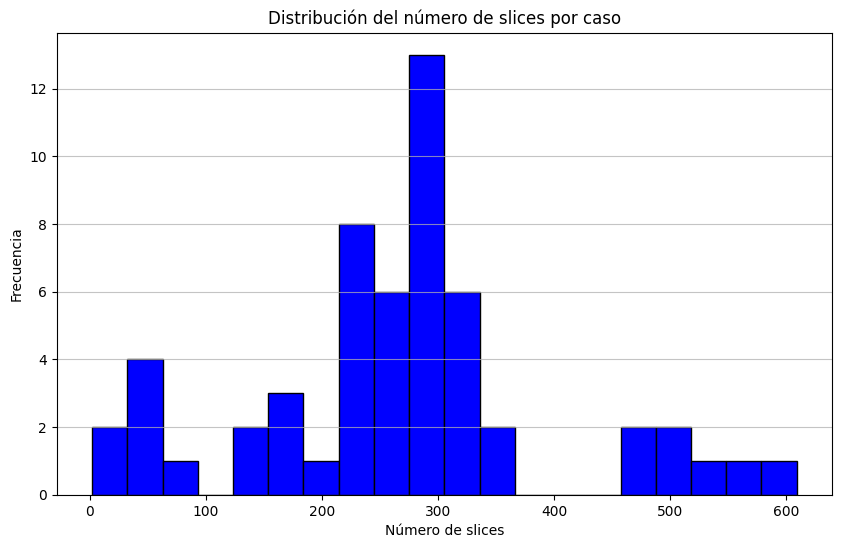

In [14]:
# Crear el histograma donde vemos las slices que tiene cada dicom
plt.figure(figsize=(10, 6))
plt.hist(slices_per_case, bins=20, color='blue', edgecolor='black')
plt.title("Distribución del número de slices por caso")
plt.xlabel("Número de slices")
plt.ylabel("Frecuencia")
plt.grid(axis='y', alpha=0.75)

# Mostrar el histograma
plt.show()

In [15]:
#Vemos cuantas slices tenemos en total 
total_slices = sum(slices_per_case)

# Mostrar el resultado
print(f"El número total de slices en todos los casos es: {total_slices}")

El número total de slices en todos los casos es: 14741


## 3D

In [20]:
class DicomDataset(Dataset):
    def __init__(self, root_path, case_indices=None, transform=None):
        """
        Inicializa el dataset.
        Args:
            root_path (str): Ruta de los casos
            case_indices (list): Lista de índices de casos a cargar.
            transform (callable, optional): Transformación a aplicar a los volúmenes.
        """
        self.root_path = root_path #donde tenemos todos las carpetas de los casos
        self.transform = transform

        # Obtener todas las carpetas de pacientes
        all_patient_dirs = [os.path.join(root_path, d) for d in sorted(os.listdir(root_path)) if os.path.isdir(os.path.join(root_path, d))]

        # Filtrar por case_indices si se proporciona
        if case_indices is not None:
            # Asegúrate de que los índices estén en el rango correcto
            case_indices = [i - 1 for i in case_indices if 1 <= i <= len(all_patient_dirs)]  # Convertir a índices base 0
            self.patient_dirs = [all_patient_dirs[i] for i in case_indices]
        else:
            self.patient_dirs = all_patient_dirs

    def __len__(self):
        """
        Devuelve el número de casos en el dataset.
        """
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        
        # Ruta al archivo DICOMDIR
        dicomdir_path = os.path.join(patient_dir, "DICOMDIR")

        if not os.path.exists(dicomdir_path):
            raise FileNotFoundError(f"No se encontró DICOMDIR en el directorio {patient_dir}")
        
        try:
            # Leer el archivo DICOMDIR
            dsdir = dcmread(dicomdir_path)

            # Crear el FileSet para el paciente
            fs = FileSet(dsdir)

            # Cargar las imágenes DICOM referenciadas en el DICOMDIR
            slices = []
            for instance in fs:
                try:
                    ds = instance.load()
                    if hasattr(ds, 'pixel_array'):  # Verificar que sea un archivo DICOM válido con datos de imagen
                        slices.append(ds)
                except (InvalidDicomError, Exception) as e:
                    print(f"Error cargando imagen DICOM: {e}")

            if not slices:
                raise ValueError(f"No se pudieron cargar imágenes DICOM válidas en {patient_dir}")

            # Ordenar por SliceLocation si está disponible
            slices = sorted(slices, key=lambda s: getattr(s, "SliceLocation", 0))

            # Convertir a volumen 3D (Tensor de PyTorch)
            volume = np.stack([s.pixel_array for s in slices], axis=2)
            volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)  # Añadir canal (1, D, H, W)

            # Normalizar el volumen (opcional, dependiendo de tus datos)
            volume = (volume - volume.min()) / (volume.max() - volume.min())

            # Obtener metadatos del paciente
            patient_id = getattr(slices[0], 'PatientID', 'Desconocido')

            # Aplicar transformaciones si se proporcionan
            if self.transform:
                volume = self.transform(volume)

            return volume, patient_id

        except Exception as e:
            print(f"Error al procesar el paciente en el directorio {patient_dir}: {e}")
            raise

Creamos un dataset para train y otro para valid. 

In [21]:
# Crear Datasets
train_dataset = DicomDataset(root_path, case_indices=train_cases)
val_dataset = DicomDataset(root_path, case_indices=val_cases)
#test_dataset = DicomDataset(root_path, test_cases)

In [22]:
# Crear DataLoaders
batch_size = 1
num_workers=2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2D
Viendo que cada caso tiene un número muy variable de slices y como volumen 3D no es fija la profundidad, vamos a optar por hacer un estudio de cada caso con slices 2D. 

Cada slice se va a tratar como una muestra independiente, es decir, ae almacenan los metadatos relevantes (PatientID, SliceLocation, etc.) junto con cada imagen.

Además, hemos visto que el tamaño de ancho y alto tambien difiere: 512x512 y 768x68. Esto depende de la máquina con la que se haya realizado la imagen. Por tanto, voy a ponerlas todas en un tamaño fijo de 512x512.

Añadimos las etiquetas del diccionario con la información del CSV para saber cada imagen si tiene complicación o no. 

### Preprocesar imágenes 
Le cambio el formato de DICOM a nifty. Corto en slices independientes. 

In [10]:
#Funcion para preprocesar las slices 2D sin depende de un dataset
def preprocess_and_save_slices_from_folders(root_dir, save_dir, labels_dict, target_size=(512, 512)):
    """
    Preprocesa las imágenes DICOM de las subcarpetas de pacientes y las guarda en archivos .npy.

    Args:
        root_dir (str): Directorio raíz que contiene las subcarpetas de los pacientes.
        save_dir (str): Directorio donde se guardarán las imágenes preprocesadas.
        labels_dict (dict): Diccionario que mapea Id_paciente a Complicación (etiqueta).
        target_size (tuple): Tamaño objetivo para redimensionar las imágenes (por defecto 512x512).
    """
    # Crear el directorio de guardado si no existe
    os.makedirs(save_dir, exist_ok=True)

    # Recorrer todas las subcarpetas de pacientes
    for patient_folder in tqdm(os.listdir(root_dir), desc="Procesando pacientes"):
        patient_path = os.path.join(root_dir, patient_folder)

        # Verificar si es una carpeta
        if not os.path.isdir(patient_path):
            continue

        # Obtener el Id_paciente (nombre de la subcarpeta)
        patient_id = patient_folder

        # Obtener la etiqueta del diccionario
        if patient_id not in labels_dict:
            print(f"Advertencia: No se encontró la etiqueta para el paciente {patient_id}. Saltando...")
            continue
        label = labels_dict[patient_id]

        # Recorrer todas las slices (archivos DICOM) en la carpeta del paciente
        for slice_filename in os.listdir(patient_path):
            slice_path = os.path.join(patient_path, slice_filename)

            # Cargar la imagen DICOM
            dicom_data = pydicom.dcmread(slice_path)
            slice_array = dicom_data.pixel_array  # Extraer el array de píxeles

            # Redimensionar la imagen al tamaño objetivo (512x512)
            if slice_array.shape != target_size:
                slice_array = resize(slice_array, target_size, mode='reflect', anti_aliasing=True)

            # Guardar la slice en un archivo .npy
            slice_save_name = f"{patient_id}_{slice_filename.split('.')[0]}.npy"
            slice_save_path = os.path.join(save_dir, slice_save_name)
            np.save(slice_save_path, slice_array)

In [11]:
# Directorios para guardar las imágenes preprocesadas
all_preprocessed_dir = "preprocessed/all"

In [29]:
#NO VOLVER A EJECUTAR
#PREPROCESAR IMAGENES ANONIMIZADOS
preprocess_and_save_slices_from_folders("datos_anonimizados", all_preprocessed_dir, labels_dict, (512, 512))

Procesando pacientes:   0%|          | 0/55 [00:00<?, ?it/s]

Procesando pacientes: 100%|██████████| 55/55 [11:59<00:00, 13.09s/it]


### Dataset 2D

In [11]:
# Directorios para guardar las imágenes preprocesadas
all_preprocessed_dir = "preprocessed/all"

In [12]:
class PreprocessedDataset(Dataset):
    def __init__(self, preprocessed_dir, labels_dict, cases):
        """
        Args:
            preprocessed_dir (str): Directorio donde están las imágenes preprocesadas.
            labels_dict (dict): Diccionario con las etiquetas de los pacientes.
            cases (list): Lista de casos (patient_id) que se incluirán en este dataset.
        """
        self.preprocessed_dir = preprocessed_dir
        self.labels_dict = labels_dict
        self.cases = cases

        # Obtener la lista de archivos .npy en el directorio
        self.slice_files = [
            os.path.join(preprocessed_dir, f) 
            for f in os.listdir(preprocessed_dir) 
            if f.endswith('.npy') and self._is_patient_in_cases(f)
        ]

    def _extract_case_number(self, patient_id):
        """
        Extrae el número de caso del patient_id.

        Args:
            patient_id (str): ID del paciente (por ejemplo, "10MANX" o "1MASh").

        Returns:
            int: Número de caso (por ejemplo, 10 o 1).
        """
        # Usar una expresión regular para encontrar todos los dígitos al principio del string
        match = re.match(r'^\d+', patient_id)
        if match:
            return int(match.group())  # Convertir a entero
        return 0  # Si no hay dígitos, devolver 0 (o un valor por defecto)

    def _is_patient_in_cases(self, filename):
        """
        Verifica si el paciente asociado a un archivo está en la lista de casos permitidos.

        Args:
            filename (str): Nombre del archivo.

        Returns:
            bool: True si el paciente está en la lista de casos, False en caso contrario.
        """
        # Extraer el patient_id del nombre del archivo
        patient_id = os.path.basename(filename).split('_')[0]
        # Extraer el número de caso del patient_id
        case_number = self._extract_case_number(patient_id)
        # Verificar si está en la lista de casos permitidos
        return case_number in self.cases

    def __len__(self):
        return len(self.slice_files)

    def __getitem__(self, idx):
        # Cargar la slice desde el archivo .npy
        slice_path = self.slice_files[idx]
        slice_2d = np.load(slice_path)  # Cargar como numpy array

        # Asegurar que tenga una dimensión de canal (1, 512, 512)
        if len(slice_2d.shape) == 2:  # Si es (512, 512), agregar dimensión de canal
            slice_2d = np.expand_dims(slice_2d, axis=0)

        # Convertir a tensor de PyTorch
        slice_2d = torch.tensor(slice_2d, dtype=torch.float32)

        # Obtener el ID del paciente desde el nombre del archivo
        filename = os.path.basename(slice_path)
        patient_id = filename.split('_')[0]

        # Obtener la etiqueta del paciente
        label = 1 if self.labels_dict[patient_id] == "Sí" else 0

        return slice_2d, label, patient_id

In [30]:
#Crear un dataset con todo
all_dataset_preprocessed = PreprocessedDataset(all_preprocessed_dir, labels_dict, all_cases)

In [13]:
#HOLD-OUT
train_dataset_2d_preprocessed=PreprocessedDataset(all_preprocessed_dir, labels_dict, train_cases)
val_dataset_2d_preprocessed=PreprocessedDataset(all_preprocessed_dir, labels_dict, val_cases)

In [15]:
# Obtener una slice del dataset
slice_2d, label, patient_id = train_dataset_2d_preprocessed[700]  # Obtener la slice 2D y su etiqueta
slice_2d = slice_2d.squeeze().numpy()  # Eliminar dimensiones adicionales y convertir a NumPy

# Obtener el tamaño de la slice
slice_size = slice_2d.shape

# Obtener la etiqueta original del diccionario
original_label = labels_dict.get(patient_id, "Desconocido")  # Si no existe, mostrar "Desconocido"


# Visualizar la slice
plt.imshow(slice_2d, cmap='gray')
#plt.title(f"Slice del paciente (Label: {'Sí' if label == 1 else 'No'})")
# plt.title(labels_dict, f"Slice del paciente (Label: )")
#plt.title(f"Paciente: {patient_id} (Label: {'Sí' if label == 1 else 'No'})")  # Mostrar ID y etiqueta
plt.title(f"Paciente: {patient_id} (Complicación: {original_label})")  # Mostrar ID y etiqueta real
plt.text(10, 20, f"Tamaño: {slice_size}", color='white', backgroundcolor='black')  # Agregar texto con el tamaño
plt.axis('off')
plt.show()

In [16]:
# Seleccionar 5 índices aleatorios del dataset
random_indices = random.sample(range(len(train_dataset_2d_preprocessed)), 5)

# Crear una figura con 5 subgráficos (1 fila, 5 columnas)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    slice_2d, label, patient_id = train_dataset_2d_preprocessed[idx]  # Obtener la slice, etiqueta y el ID del paciente
    slice_2d = slice_2d.squeeze().numpy()  # Convertir a NumPy
    slice_size = slice_2d.shape  # Obtener el tamaño de la slice

    # Obtener la etiqueta original del diccionario
    original_label = labels_dict.get(patient_id, "Desconocido")

    # Mostrar la imagen en su subgráfico correspondiente
    axes[i].imshow(slice_2d, cmap='gray')
    axes[i].set_title(f"Paciente: {patient_id}\nComplicación: {original_label}")
    axes[i].text(10, 20, f"Tamaño: {slice_size}", color='white', backgroundcolor='black')
    axes[i].axis('off')  # Ocultar ejes

# Ajustar espaciado y mostrar la figura
plt.tight_layout()
plt.show()



In [ ]:
# Obtener los patient_id únicos en el dataset de entrenamiento
unique_patient_ids = set()
for slice_2d, label, patient_id in train_dataset_2d_preprocessed:
    unique_patient_ids.add((patient_id))

print("Pacientes en train:", sorted(unique_patient_ids))

Pacientes en train: ['10MANX', '11HASh', '12HNSN', '13HANX', '15MANX', '16HLNX', '17MANX', '18MANX', '19MANX', '1MASh', '22MTNX', '23MMNX', '24MANX', '25HTNX', '26HMNX', '27HASD', '28HCGNX', '29HMeSX', '2HENX', '30MANX', '31MGNX', '32HENX', '33MANX', '34MASN', '35HENX', '36HENX', '37HPNX', '38HANX', '39MFNX', '3HENX', '40HANX', '41HAsNX', '42HNnNX', '43HESH', '45HNeSN', '46HANX', '47HESN', '48HTtSN', '4HLSh', '5HANX', '6MASN', '7MPNX', '8HENX', '9MANX']


### Modelo 

#### EfficientNetV2-S

In [14]:
#Activamos la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [15]:
#EfficientNetV2-S preentrenado (entrenando todas las capas)
model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")

# Convolucion para modificar la primera capa para aceptar imágenes en escala de grises (1 canal en vez de 3)
model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# Modificar la última capa para clasificación binaria
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(num_features, 1),  # Salida binaria
    nn.Sigmoid()  # Activación sigmoide para clasificación binaria
)

# Enviar modelo a GPU si está disponible
model = model.to(device)

# Mostrar la arquitectura modificada
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
# Definir función de pérdida y optimizador
criterion = nn.BCELoss()  # Binary Cross Entropy para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#Definimos los dataloaders
train_dataloader_2d = DataLoader(train_dataset_2d_preprocessed, batch_size=32, shuffle=True, num_workers=8)
val_dataloader_2d = DataLoader(val_dataset_2d_preprocessed, batch_size=32, shuffle=True, num_workers=8)

In [18]:
# Inspeccionar la forma de las imágenes
for images, labels, patient_ids in train_dataloader_2d:
    print(images.shape)  # Debería ser [batch_size, channels, height, width]
    break

torch.Size([32, 1, 512, 512])


In [ ]:
#MAS COMPLETO (GRÁFICAS Y MÉTRICAS)

# Listas para almacenar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

# Loop de entrenamiento y validación
for epoch in range(10):  # Número de épocas
    model.train()  # Modo entrenamiento
    epoch_train_loss = 0.0
    epoch_train_preds = []
    epoch_train_labels = []

    # Entrenamiento
    for images, labels, patient_ids in tqdm(train_dataloader_2d, desc=f"Entrenando Época {epoch+1}"):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        #outputs = model(images).squeeze()
        outputs = model(images)  # No usar .squeeze() aquí

        # Ajustar la forma de labels
        labels = labels.unsqueeze(1)  # Convertir de [bs] a [bs, 1] (si no coinciden la dimensionalidad de labels y outputs hay problemas)

        # Inspeccionar formas
        # print(f"Forma de outputs: {outputs.shape}")
        # print(f"Forma de labels: {labels.shape}")

        loss = criterion(outputs, labels) #outputs y labels tengan misma dimensionalidad
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
        epoch_train_preds.extend(preds.cpu().numpy().flatten())
        epoch_train_labels.extend(labels.cpu().numpy())

    # Calcular métricas de entrenamiento
    train_loss = epoch_train_loss / len(train_dataloader_2d)
    train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
    train_f1 = f1_score(epoch_train_labels, epoch_train_preds)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validación
    model.eval()  # Modo evaluación
    epoch_val_loss = 0.0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids in tqdm(val_dataloader_2d, desc=f"Validando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            #Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            epoch_val_preds.extend(preds.cpu().numpy().flatten())
            epoch_val_labels.extend(labels.cpu().numpy())

    # Calcular métricas de validación
    val_loss = epoch_val_loss / len(val_dataloader_2d)
    val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
    val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Mostrar métricas por época
    print(f"Época {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-Score: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")

# Gráficas
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida por Época")
plt.legend()

# Gráfica de accuracy y F1-score
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.plot(train_f1_scores, label="Train F1-Score")
plt.plot(val_f1_scores, label="Val F1-Score")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.title("Accuracy y F1-Score por Época")
plt.legend()

plt.tight_layout()
plt.show()

Entrenando Época 1:   0%|          | 0/376 [00:00<?, ?it/s]

Validando Época 1: 100%|██████████| 77/77 [00:29<00:00,  2.62it/s]


Época 1
  Train Loss: 0.3926, Train Accuracy: 0.8160, Train F1-Score: 0.5339
  Val Loss: 1.5577, Val Accuracy: 0.7452, Val F1-Score: 0.0000


Entrenando Época 2:  85%|████████▍ | 318/376 [02:48<00:30,  1.91it/s]

#### Fine tuning
Vamos a congerlar las capas inciales (ya han aprendido características generales de las imágenes como bordes o texturas)

In [23]:
# Congelar todas las capas excepto las últimas
for param in model.features.parameters():
    param.requires_grad = False  # Congelar parámetros

# Asegurarse de que las capas del clasificador se entrenen
for param in model.classifier.parameters():
    param.requires_grad = True

In [26]:
# Definir el optimizador solo para las capas no congeladas
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # Solo parámetros no congelados
    lr=0.0001,  # Learning rate más bajo
    weight_decay=1e-5  # Regularización L2
)

Entrenando Época 1:   0%|          | 0/398 [00:00<?, ?it/s]

Validando Época 1: 100%|██████████| 64/64 [00:09<00:00,  6.57it/s]


Época 1
  Train Loss: 0.5599, Train Accuracy: 0.7555, Train F1-Score: 0.0389
  Val Loss: 0.6746, Val Accuracy: 0.5761, Val F1-Score: 0.0000


Validando Época 2: 100%|██████████| 64/64 [00:09<00:00,  6.57it/s]


Época 2
  Train Loss: 0.5236, Train Accuracy: 0.7681, Train F1-Score: 0.0258
  Val Loss: 0.7394, Val Accuracy: 0.5503, Val F1-Score: 0.0000


Validando Época 3: 100%|██████████| 64/64 [00:09<00:00,  6.61it/s]


Época 3
  Train Loss: 0.5090, Train Accuracy: 0.7756, Train F1-Score: 0.1025
  Val Loss: 0.7971, Val Accuracy: 0.4541, Val F1-Score: 0.0000


Validando Época 4: 100%|██████████| 64/64 [00:09<00:00,  6.58it/s]


Época 4
  Train Loss: 0.4924, Train Accuracy: 0.7826, Train F1-Score: 0.1748
  Val Loss: 0.8590, Val Accuracy: 0.4284, Val F1-Score: 0.0000


Validando Época 5: 100%|██████████| 64/64 [00:09<00:00,  6.69it/s]


Época 5
  Train Loss: 0.4819, Train Accuracy: 0.7881, Train F1-Score: 0.2350
  Val Loss: 0.9021, Val Accuracy: 0.4105, Val F1-Score: 0.0000


Validando Época 6: 100%|██████████| 64/64 [00:09<00:00,  6.77it/s]


Época 6
  Train Loss: 0.4727, Train Accuracy: 0.7891, Train F1-Score: 0.2594
  Val Loss: 0.9269, Val Accuracy: 0.4140, Val F1-Score: 0.0000


Validando Época 7: 100%|██████████| 64/64 [00:09<00:00,  6.61it/s]


Época 7
  Train Loss: 0.4625, Train Accuracy: 0.7928, Train F1-Score: 0.2860
  Val Loss: 0.9710, Val Accuracy: 0.4100, Val F1-Score: 0.0000


Validando Época 8: 100%|██████████| 64/64 [00:09<00:00,  6.71it/s]


Época 8
  Train Loss: 0.4590, Train Accuracy: 0.7970, Train F1-Score: 0.3125
  Val Loss: 0.9951, Val Accuracy: 0.4085, Val F1-Score: 0.0017


Validando Época 9: 100%|██████████| 64/64 [00:09<00:00,  6.67it/s]


Época 9
  Train Loss: 0.4509, Train Accuracy: 0.7985, Train F1-Score: 0.3295
  Val Loss: 1.0164, Val Accuracy: 0.4065, Val F1-Score: 0.0000


Validando Época 10: 100%|██████████| 64/64 [00:09<00:00,  6.63it/s]


Época 10
  Train Loss: 0.4502, Train Accuracy: 0.7975, Train F1-Score: 0.3346
  Val Loss: 1.0437, Val Accuracy: 0.4085, Val F1-Score: 0.0000


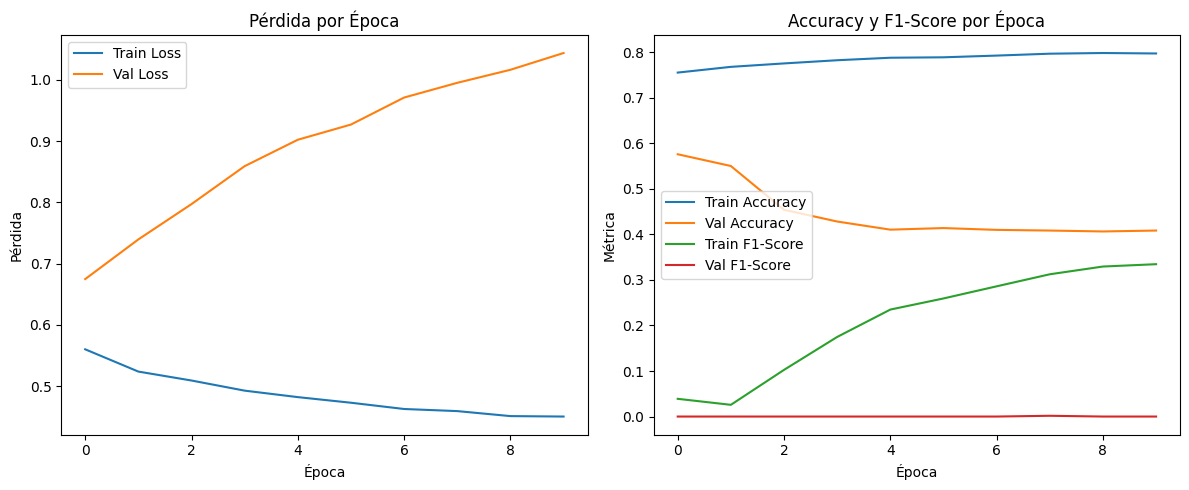

In [ ]:
# Listas para almacenar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

# Loop de entrenamiento y validación
for epoch in range(10):  # Número de épocas
    model.train()  # Modo entrenamiento
    epoch_train_loss = 0.0
    epoch_train_preds = []
    epoch_train_labels = []

    # Entrenamiento
    for images, labels, patient_ids in tqdm(train_dataloader_2d, desc=f"Entrenando Época {epoch+1}"):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ajustar la forma de labels
        labels = labels.unsqueeze(1)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
        epoch_train_preds.extend(preds.cpu().numpy().flatten())
        epoch_train_labels.extend(labels.cpu().numpy())

    # Calcular métricas de entrenamiento
    train_loss = epoch_train_loss / len(train_dataloader_2d)
    train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
    train_f1 = f1_score(epoch_train_labels, epoch_train_preds)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validación
    model.eval()  # Modo evaluación
    epoch_val_loss = 0.0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids in tqdm(val_dataloader_2d, desc=f"Validando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            epoch_val_preds.extend(preds.cpu().numpy().flatten())
            epoch_val_labels.extend(labels.cpu().numpy())

    # Calcular métricas de validación
    val_loss = epoch_val_loss / len(val_dataloader_2d)
    val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
    val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Mostrar métricas por época
    print(f"Época {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-Score: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")

    # Gráficas
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida por Época")
plt.legend()

# Gráfica de accuracy y F1-score
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.plot(train_f1_scores, label="Train F1-Score")
plt.plot(val_f1_scores, label="Val F1-Score")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.title("Accuracy y F1-Score por Época")
plt.legend()

plt.tight_layout()
plt.show()

#### Efficientnet-v2-s con fine-tuning y 5-fold

In [27]:
# tenemos en la carpeta all todos las imagenes del 1 al 60 preprocesadas. Luego vamos a trabajar y dividir all_cases

# Crear el dataset con todos los casos con las imagenes preprocesadas
all_dataset_preprocessed = PreprocessedDataset(all_preprocessed_dir, labels_dict)

# Crear el dataloader preprocesado
all_loader_2d_preprocessed = DataLoader(all_dataset_preprocessed, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)


Fold 1/5
Validando Época 3: 100%|██████████| 185/185 [00:15<00:00, 11.80it/s]


Validando Época 1: 100%|██████████| 185/185 [00:30<00:00,  6.14it/s]


Época 1
  Train Loss: 0.1044, Train Accuracy: 0.9591, Train F1-Score: 0.9185
  Val Loss: 0.0174, Val Accuracy: 0.9946, Val F1-Score: 0.9895


Validando Época 2: 100%|██████████| 185/185 [00:27<00:00,  6.62it/s]


Época 2
  Train Loss: 0.0195, Train Accuracy: 0.9940, Train F1-Score: 0.9885
  Val Loss: 0.0010, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 3: 100%|██████████| 185/185 [00:15<00:00, 11.89it/s]


Época 3
  Train Loss: 0.0082, Train Accuracy: 0.9976, Train F1-Score: 0.9954
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Entrenando Época 4:  39%|███▊      | 285/737 [01:20<02:06,  3.59it/s]

Época 3
  Train Loss: 0.0084, Train Accuracy: 0.9981, Train F1-Score: 0.9965
  Val Loss: 0.0019, Val Accuracy: 0.9997, Val F1-Score: 0.9993


Validando Época 4: 100%|██████████| 185/185 [00:16<00:00, 11.02it/s]


Época 4
  Train Loss: 0.0155, Train Accuracy: 0.9957, Train F1-Score: 0.9918
  Val Loss: 0.0257, Val Accuracy: 0.9942, Val F1-Score: 0.9885


Validando Época 5: 100%|██████████| 185/185 [00:16<00:00, 10.89it/s]


Época 5
  Train Loss: 0.0032, Train Accuracy: 0.9992, Train F1-Score: 0.9984
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 6: 100%|██████████| 185/185 [00:15<00:00, 11.70it/s]


Época 6
  Train Loss: 0.0094, Train Accuracy: 0.9972, Train F1-Score: 0.9947
  Val Loss: 0.0058, Val Accuracy: 0.9990, Val F1-Score: 0.9979


Validando Época 7: 100%|██████████| 185/185 [00:15<00:00, 11.77it/s]


Época 7
  Train Loss: 0.0012, Train Accuracy: 0.9997, Train F1-Score: 0.9995
  Val Loss: 0.0230, Val Accuracy: 0.9925, Val F1-Score: 0.9847


Validando Época 8: 100%|██████████| 185/185 [00:16<00:00, 11.00it/s]


Época 8
  Train Loss: 0.0066, Train Accuracy: 0.9984, Train F1-Score: 0.9969
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 9: 100%|██████████| 185/185 [00:18<00:00, 10.16it/s]


Época 9
  Train Loss: 0.0069, Train Accuracy: 0.9980, Train F1-Score: 0.9963
  Val Loss: 0.0003, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 10: 100%|██████████| 185/185 [00:16<00:00, 11.02it/s]


Época 10
  Train Loss: 0.0133, Train Accuracy: 0.9980, Train F1-Score: 0.9963
  Val Loss: 0.0008, Val Accuracy: 1.0000, Val F1-Score: 1.0000

Fold 3/5


Validando Época 1: 100%|██████████| 185/185 [00:16<00:00, 10.92it/s]


Época 1
  Train Loss: 0.1021, Train Accuracy: 0.9630, Train F1-Score: 0.9265
  Val Loss: 0.0227, Val Accuracy: 0.9888, Val F1-Score: 0.9780


Validando Época 2: 100%|██████████| 185/185 [00:16<00:00, 11.53it/s]


Época 2
  Train Loss: 0.0179, Train Accuracy: 0.9946, Train F1-Score: 0.9896
  Val Loss: 0.0258, Val Accuracy: 0.9874, Val F1-Score: 0.9764


Validando Época 3: 100%|██████████| 185/185 [00:16<00:00, 11.52it/s]


Época 3
  Train Loss: 0.0086, Train Accuracy: 0.9979, Train F1-Score: 0.9959
  Val Loss: 0.0005, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 4: 100%|██████████| 185/185 [00:17<00:00, 10.50it/s]


Época 4
  Train Loss: 0.0088, Train Accuracy: 0.9977, Train F1-Score: 0.9956
  Val Loss: 0.0127, Val Accuracy: 0.9946, Val F1-Score: 0.9895


Validando Época 5: 100%|██████████| 185/185 [00:16<00:00, 10.94it/s]


Época 5
  Train Loss: 0.0051, Train Accuracy: 0.9986, Train F1-Score: 0.9974
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 6: 100%|██████████| 185/185 [00:15<00:00, 11.86it/s]


Época 6
  Train Loss: 0.0006, Train Accuracy: 0.9999, Train F1-Score: 0.9998
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 7: 100%|██████████| 185/185 [00:15<00:00, 11.91it/s]


Época 7
  Train Loss: 0.0001, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 8: 100%|██████████| 185/185 [00:15<00:00, 11.81it/s]


Época 8
  Train Loss: 0.0202, Train Accuracy: 0.9943, Train F1-Score: 0.9891
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 9: 100%|██████████| 185/185 [00:15<00:00, 11.96it/s]


Época 9
  Train Loss: 0.0004, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 10: 100%|██████████| 185/185 [00:15<00:00, 11.90it/s]


Época 10
  Train Loss: 0.0129, Train Accuracy: 0.9982, Train F1-Score: 0.9966
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000

Fold 4/5


Validando Época 1: 100%|██████████| 185/185 [00:15<00:00, 11.84it/s]


Época 1
  Train Loss: 0.1172, Train Accuracy: 0.9546, Train F1-Score: 0.9091
  Val Loss: 0.0037, Val Accuracy: 0.9997, Val F1-Score: 0.9994


Validando Época 2: 100%|██████████| 185/185 [00:15<00:00, 11.88it/s]


Época 2
  Train Loss: 0.0157, Train Accuracy: 0.9950, Train F1-Score: 0.9904
  Val Loss: 0.0021, Val Accuracy: 0.9997, Val F1-Score: 0.9994


Validando Época 3: 100%|██████████| 185/185 [00:15<00:00, 11.81it/s]


Época 3
  Train Loss: 0.0048, Train Accuracy: 0.9986, Train F1-Score: 0.9974
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 4: 100%|██████████| 185/185 [00:15<00:00, 11.67it/s]


Época 4
  Train Loss: 0.0123, Train Accuracy: 0.9960, Train F1-Score: 0.9923
  Val Loss: 0.0061, Val Accuracy: 0.9980, Val F1-Score: 0.9961


Validando Época 5: 100%|██████████| 185/185 [00:15<00:00, 11.84it/s]


Época 5
  Train Loss: 0.0114, Train Accuracy: 0.9984, Train F1-Score: 0.9969
  Val Loss: 0.0003, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 6: 100%|██████████| 185/185 [00:15<00:00, 11.83it/s]


Época 6
  Train Loss: 0.0212, Train Accuracy: 0.9960, Train F1-Score: 0.9923
  Val Loss: 0.0211, Val Accuracy: 0.9953, Val F1-Score: 0.9910


Validando Época 7: 100%|██████████| 185/185 [00:15<00:00, 11.75it/s]


Época 7
  Train Loss: 0.0071, Train Accuracy: 0.9989, Train F1-Score: 0.9979
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 8: 100%|██████████| 185/185 [00:15<00:00, 11.79it/s]


Época 8
  Train Loss: 0.0045, Train Accuracy: 0.9991, Train F1-Score: 0.9982
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 9: 100%|██████████| 185/185 [00:15<00:00, 11.75it/s]


Época 9
  Train Loss: 0.0002, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 10: 100%|██████████| 185/185 [00:15<00:00, 11.96it/s]


Época 10
  Train Loss: 0.0073, Train Accuracy: 0.9977, Train F1-Score: 0.9956
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000

Fold 5/5


Validando Época 1: 100%|██████████| 185/185 [00:15<00:00, 11.82it/s]


Época 1
  Train Loss: 0.1036, Train Accuracy: 0.9629, Train F1-Score: 0.9252
  Val Loss: 0.0032, Val Accuracy: 0.9990, Val F1-Score: 0.9981


Validando Época 2: 100%|██████████| 185/185 [00:15<00:00, 11.87it/s]


Época 2
  Train Loss: 0.0165, Train Accuracy: 0.9958, Train F1-Score: 0.9918
  Val Loss: 0.0027, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 3: 100%|██████████| 185/185 [00:15<00:00, 11.76it/s]


Época 3
  Train Loss: 0.0117, Train Accuracy: 0.9972, Train F1-Score: 0.9946
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 4: 100%|██████████| 185/185 [00:15<00:00, 11.78it/s]


Época 4
  Train Loss: 0.0137, Train Accuracy: 0.9966, Train F1-Score: 0.9934
  Val Loss: 0.0057, Val Accuracy: 0.9980, Val F1-Score: 0.9963


Validando Época 5: 100%|██████████| 185/185 [00:15<00:00, 11.87it/s]


Época 5
  Train Loss: 0.0091, Train Accuracy: 0.9973, Train F1-Score: 0.9947
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 6: 100%|██████████| 185/185 [00:15<00:00, 11.85it/s]


Época 6
  Train Loss: 0.0152, Train Accuracy: 0.9966, Train F1-Score: 0.9934
  Val Loss: 0.0002, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 7: 100%|██████████| 185/185 [00:15<00:00, 11.92it/s]


Época 7
  Train Loss: 0.0306, Train Accuracy: 0.9970, Train F1-Score: 0.9942
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 8: 100%|██████████| 185/185 [00:15<00:00, 11.81it/s]


Época 8
  Train Loss: 0.0003, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0001, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 9: 100%|██████████| 185/185 [00:15<00:00, 11.80it/s]


Época 9
  Train Loss: 0.0003, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


Validando Época 10: 100%|██████████| 185/185 [00:15<00:00, 11.78it/s]


Época 10
  Train Loss: 0.0001, Train Accuracy: 1.0000, Train F1-Score: 1.0000
  Val Loss: 0.0000, Val Accuracy: 1.0000, Val F1-Score: 1.0000


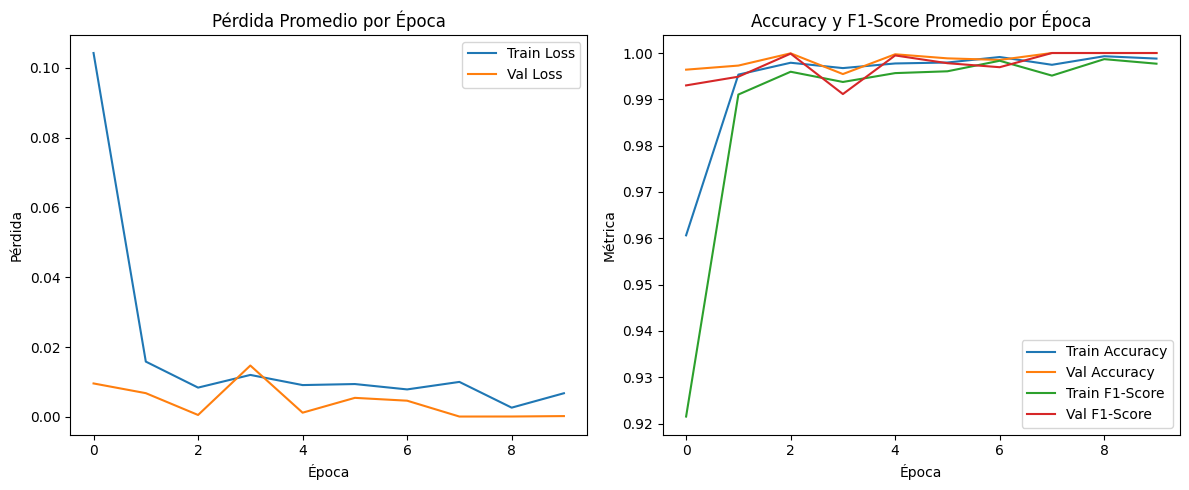

In [ ]:
# Convertir tu dataset a un formato compatible con KFold
X = np.arange(len(all_dataset_preprocessed))  # Índices de las muestras
y = np.array([label for _, label, _ in all_dataset_preprocessed])  # Etiquetas

# Inicializar KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas promedio
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_train_f1_scores = []
all_val_f1_scores = []

# Bucle de 5-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/5")

    # Crear datasets de entrenamiento y validación para este fold
    train_fold_dataset = torch.utils.data.Subset(all_dataset_preprocessed, train_idx)
    val_fold_dataset = torch.utils.data.Subset(all_dataset_preprocessed, val_idx)

    # Crear DataLoaders para este fold
    train_fold_loader = DataLoader(train_fold_dataset, batch_size=16, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=16, shuffle=False)

    # Reiniciar el modelo para cada fold
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Sequential(
        nn.Linear(num_features, 1),  # Salida binaria
        nn.Sigmoid()  # Activación sigmoide para clasificación binaria
    )
    model = model.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Listas para almacenar métricas de este fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    # Loop de entrenamiento y validación para este fold
    for epoch in range(10):  # Número de épocas
        model.train()  # Modo entrenamiento
        epoch_train_loss = 0.0
        epoch_train_preds = []
        epoch_train_labels = []

        # Entrenamiento
        for images, labels, patient_ids in tqdm(train_fold_loader, desc=f"Entrenando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            epoch_train_preds.extend(preds.cpu().numpy().flatten())
            epoch_train_labels.extend(labels.cpu().numpy())

        # Calcular métricas de entrenamiento
        train_loss = epoch_train_loss / len(train_fold_loader)
        train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
        train_f1 = f1_score(epoch_train_labels, epoch_train_preds, zero_division=0)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)

        # Validación
        model.eval()  # Modo evaluación
        epoch_val_loss = 0.0
        epoch_val_preds = []
        epoch_val_labels = []

        with torch.no_grad():  # Desactivar cálculo de gradientes
            for images, labels, patient_ids in tqdm(val_fold_loader, desc=f"Validando Época {epoch+1}"):
                images, labels = images.to(device), labels.float().to(device)

                outputs = model(images)

                # Ajustar la forma de labels
                labels = labels.unsqueeze(1)

                # Calcular la pérdida
                loss = criterion(outputs, labels)

                epoch_val_loss += loss.item()
                preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
                epoch_val_preds.extend(preds.cpu().numpy().flatten())
                epoch_val_labels.extend(labels.cpu().numpy())

        # Calcular métricas de validación
        val_loss = epoch_val_loss / len(val_fold_loader)
        val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
        val_f1 = f1_score(epoch_val_labels, epoch_val_preds, zero_division=0)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        # Mostrar métricas por época
        print(f"Época {epoch+1}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-Score: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")

    # Guardar métricas de este fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    all_train_f1_scores.append(train_f1_scores)
    all_val_f1_scores.append(val_f1_scores)

# Calcular métricas promedio de todos los folds
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)
avg_train_accuracies = np.mean(all_train_accuracies, axis=0)
avg_val_accuracies = np.mean(all_val_accuracies, axis=0)
avg_train_f1_scores = np.mean(all_train_f1_scores, axis=0)
avg_val_f1_scores = np.mean(all_val_f1_scores, axis=0)

# Gráficas de métricas promedio
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label="Train Loss")
plt.plot(avg_val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida Promedio por Época")
plt.legend()

# Gráfica de accuracy y F1-score
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracies, label="Train Accuracy")
plt.plot(avg_val_accuracies, label="Val Accuracy")
plt.plot(avg_train_f1_scores, label="Train F1-Score")
plt.plot(avg_val_f1_scores, label="Val F1-Score")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.title("Accuracy y F1-Score Promedio por Época")
plt.legend()

plt.tight_layout()
plt.show()

#### Efficientnet-v2-s y 5-fold con test (sin validacion)

In [18]:
# tenemos en la carpeta all todos las imagenes del 1 al 60 preprocesadas. Luego vamos a trabajar y dividir all_cases

# Crear el dataset con todos los casos con las imagenes preprocesadas
all_dataset_preprocessed = PreprocessedDataset(all_preprocessed_dir, labels_dict)


In [28]:
# Convertir tu dataset a un formato compatible con KFold
X = np.arange(len(all_dataset_preprocessed))  # Índices de las muestras
y = np.array([label for _, label, _ in all_dataset_preprocessed])  # Etiquetas

# Inicializar KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas de "test"
all_test_losses = []
all_test_accuracies = []
all_test_f1_scores = []

# Bucle de 5-Fold Cross-Validation (usando un fold como "test")
for fold, (train_val_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/5")

    # Crear datasets de entrenamiento+validación y test para este fold
    train_val_dataset = torch.utils.data.Subset(all_dataset_preprocessed, train_val_idx)
    test_dataset = torch.utils.data.Subset(all_dataset_preprocessed, test_idx)

    # Crear DataLoaders para este fold
    train_val_loader = DataLoader(train_val_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

    # Reiniciar el modelo para cada fold
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Sequential(
        nn.Linear(num_features, 1),  # Salida binaria
        nn.Sigmoid()  # Activación sigmoide para clasificación binaria
    )
    model = model.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Entrenar el modelo en train+validation
    for epoch in range(10):  # Número de épocas
        model.train()  # Modo entrenamiento
        epoch_train_loss = 0.0

        # Entrenamiento
        for images, labels, patient_ids in tqdm(train_val_loader, desc=f"Entrenando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

    # Evaluar el modelo en el conjunto de "test"
    model.eval()  # Modo evaluación
    test_loss = 0.0
    test_preds = []
    test_labels = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids in tqdm(test_loader, desc="Evaluando en Test"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            test_preds.extend(preds.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy())

    # Calcular métricas en "test"
    test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)

    # Guardar métricas de este fold
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)
    all_test_f1_scores.append(test_f1)

    # Mostrar métricas por fold
    print(f"Fold {fold + 1}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")

# Calcular métricas promedio de todos los folds
avg_test_loss = np.mean(all_test_losses)
avg_test_accuracy = np.mean(all_test_accuracies)
avg_test_f1 = np.mean(all_test_f1_scores)

print(f"\nMétricas Promedio en Test:")
print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Test F1-Score: {avg_test_f1:.4f}")


Fold 1/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.43it/s]


Fold 1
  Test Loss: 0.0008, Test Accuracy: 1.0000, Test F1-Score: 1.0000

Fold 2/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.92it/s]


Fold 2
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000

Fold 3/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.67it/s]


Fold 3
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000

Fold 4/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.79it/s]


Fold 4
  Test Loss: 0.0007, Test Accuracy: 1.0000, Test F1-Score: 1.0000

Fold 5/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.86it/s]

Fold 5
  Test Loss: 0.0001, Test Accuracy: 1.0000, Test F1-Score: 1.0000

Métricas Promedio en Test:
  Test Loss: 0.0003, Test Accuracy: 1.0000, Test F1-Score: 1.0000


#### Efficientnet-v2-s y 5-fold estratificado (con test y sin validacion)

In [24]:
import pandas as pd  # Importar pandas para crear la tabla

# Convertir tu dataset a un formato compatible con StratifiedKFold
X = np.arange(len(all_dataset_preprocessed))  # Índices de las muestras
y = np.array([label for _, label, _ in all_dataset_preprocessed])  # Etiquetas

# Inicializar StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Estratificado

# Listas para almacenar métricas de "test"
all_test_losses = []
all_test_accuracies = []
all_test_f1_scores = []

# Lista para almacenar los resultados de cada fold
all_fold_results = []

# Bucle de 5-Fold Cross-Validation Estratificado (usando un fold como "test")
for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):  # Pasar X e y a skf.split
    print(f"\nFold {fold + 1}/5")

    # Crear datasets de entrenamiento+validación y test para este fold
    train_val_dataset = torch.utils.data.Subset(all_dataset_preprocessed, train_val_idx)
    test_dataset = torch.utils.data.Subset(all_dataset_preprocessed, test_idx)

    # Crear DataLoaders para este fold
    train_val_loader = DataLoader(train_val_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

    # Reiniciar el modelo para cada fold
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Sequential(
        nn.Linear(num_features, 1),  # Salida binaria
        nn.Sigmoid()  # Activación sigmoide para clasificación binaria
    )
    model = model.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Entrenar el modelo en train+validation
    for epoch in range(10):  # Número de épocas
        model.train()  # Modo entrenamiento
        epoch_train_loss = 0.0

        # Entrenamiento
        for images, labels, patient_ids in tqdm(train_val_loader, desc=f"Entrenando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

    # Evaluar el modelo en el conjunto de "test"
    model.eval()  # Modo evaluación
    test_loss = 0.0
    test_preds = []
    test_labels = []
    test_ids = []  # Lista para almacenar los IDs de las imágenes
    test_probs = []  # Lista para almacenar las probabilidades de predicción

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids in tqdm(test_loader, desc="Evaluando en Test"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            test_preds.extend(preds.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy())
            test_ids.extend(patient_ids)  # Almacenar los IDs de las imágenes
            test_probs.extend(outputs.cpu().numpy().flatten())  # Almacenar las probabilidades de predicción

    # Calcular métricas en "test"
    test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)

    # Guardar métricas de este fold
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)
    all_test_f1_scores.append(test_f1)

    # Crear un DataFrame con los resultados de este fold
    fold_results = pd.DataFrame({
        "ID": test_ids,  # ID de la imagen
        "Clase Real": test_labels,  # Clase real (0 o 1)
        "Predicción": test_preds,  # Predicción del modelo (0 o 1)
        "Probabilidad": test_probs  # Probabilidad de la predicción
    })

    # Guardar los resultados de este fold
    all_fold_results.append(fold_results)

    # Mostrar métricas por fold
    print(f"Fold {fold + 1}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")
    print(f"  Resultados en Test:")
    print(fold_results)  # Mostrar la tabla de resultados de este fold

# Calcular métricas promedio de todos los folds
avg_test_loss = np.mean(all_test_losses)
avg_test_accuracy = np.mean(all_test_accuracies)
avg_test_f1 = np.mean(all_test_f1_scores)

print(f"\nMétricas Promedio en Test:")
print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Test F1-Score: {avg_test_f1:.4f}")

# Combinar los resultados de todos los folds en una sola tabla
all_results = pd.concat(all_fold_results, ignore_index=True)

# Mostrar la tabla completa con todos los resultados
print("\nResultados Completos en Test:")
print(all_results)


Fold 1/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.89it/s]


Fold 1
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     13HANX      [0.0]         0.0  3.783434e-07
1     17MANX      [0.0]         0.0  2.692944e-07
2     31MGNX      [0.0]         0.0  5.884536e-07
3     39MFNX      [0.0]         0.0  1.245013e-05
4     39MFNX      [0.0]         0.0  7.708994e-06
...      ...        ...         ...           ...
2944   2HENX      [0.0]         0.0  5.072463e-06
2945  47HESN      [1.0]         1.0  9.999985e-01
2946  51HFNX      [0.0]         0.0  5.888449e-06
2947  27HASD      [1.0]         1.0  9.999998e-01
2948  53HANX      [0.0]         0.0  1.101405e-06

[2949 rows x 4 columns]

Fold 2/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 14.01it/s]


Fold 2
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000
  Resultados en Test:
           ID Clase Real  Predicción  Probabilidad
0      10MANX      [0.0]         0.0      0.000025
1      13HANX      [0.0]         0.0      0.000006
2      16HLNX      [0.0]         0.0      0.000017
3      27HASD      [1.0]         1.0      0.999997
4      27HASD      [1.0]         1.0      0.999999
...       ...        ...         ...           ...
2943   25HTNX      [0.0]         0.0      0.000015
2944  45HNeSN      [1.0]         1.0      0.999992
2945  42HNnNX      [0.0]         0.0      0.000039
2946  45HNeSN      [1.0]         1.0      0.999997
2947   22MTNX      [0.0]         0.0      0.000030

[2948 rows x 4 columns]

Fold 3/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.81it/s]


Fold 3
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     22MTNX      [0.0]         0.0      0.000004
1     24MANX      [0.0]         0.0      0.000030
2     25HTNX      [0.0]         0.0      0.000007
3     33MANX      [0.0]         0.0      0.000003
4     33MANX      [0.0]         0.0      0.000005
...      ...        ...         ...           ...
2943   8HENX      [0.0]         0.0      0.000005
2944  31MGNX      [0.0]         0.0      0.000008
2945  32HENX      [0.0]         0.0      0.000001
2946  32HENX      [0.0]         0.0      0.000001
2947   3HENX      [0.0]         0.0      0.000004

[2948 rows x 4 columns]

Fold 4/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.82it/s]


Fold 4
  Test Loss: 0.0000, Test Accuracy: 1.0000, Test F1-Score: 1.0000
  Resultados en Test:
           ID Clase Real  Predicción  Probabilidad
0      10MANX      [0.0]         0.0  3.165654e-07
1      12HNSN      [1.0]         1.0  9.999994e-01
2      17MANX      [0.0]         0.0  3.825685e-06
3      19MANX      [0.0]         0.0  7.053796e-05
4      26HMNX      [0.0]         0.0  1.459215e-06
...       ...        ...         ...           ...
2943    5HANX      [0.0]         0.0  2.161279e-05
2944   40HANX      [0.0]         0.0  5.172830e-07
2945  28HCGNX      [0.0]         0.0  1.334558e-07
2946  45HNeSN      [1.0]         1.0  9.999999e-01
2947    9MANX      [0.0]         0.0  6.980739e-07

[2948 rows x 4 columns]

Fold 5/5


Evaluando en Test: 100%|██████████| 185/185 [00:13<00:00, 13.83it/s]

Fold 5
  Test Loss: 0.0067, Test Accuracy: 0.9969, Test F1-Score: 0.9942
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     12HNSN      [1.0]         1.0      0.999943
1     25HTNX      [0.0]         0.0      0.000420
2     27HASD      [1.0]         1.0      0.999924
3      2HENX      [0.0]         0.0      0.000302
4     40HANX      [0.0]         0.0      0.000006
...      ...        ...         ...           ...
2943  40HANX      [0.0]         0.0      0.000009
2944  40HANX      [0.0]         0.0      0.000007
2945  38HANX      [0.0]         0.0      0.000010
2946  60HESN      [1.0]         1.0      0.997567
2947   2HENX      [0.0]         0.0      0.000058

[2948 rows x 4 columns]

Métricas Promedio en Test:
  Test Loss: 0.0014, Test Accuracy: 0.9994, Test F1-Score: 0.9988

Resultados Completos en Test:
           ID Clase Real  Predicción  Probabilidad
0      13HANX      [0.0]         0.0  3.783434e-07
1      17MANX      [0.0]         0.0  2.692944e-07
2 

Vemos como hace perfecta la predicción. Esto se debe a que estamos sacando de cada paciente muchas slices, por lo que va haber slices de un mismo paciente tanto en train como en test. 

A continuación vamos a agrupar por pacientes las slices para que el test sean realmente datos que no hayamos visto nunca. 

#### StratifiedGroupKFold (5-fold estratificado agrupado por pacientes)

In [26]:
# Convertir tu dataset a un formato compatible con StratifiedGroupKFold
X = np.arange(len(all_dataset_preprocessed))  # Índices de las muestras
y = np.array([label for _, label, _ in all_dataset_preprocessed])  # Etiquetas
groups = np.array([patient_id for _, _, patient_id in all_dataset_preprocessed])  # IDs de los pacientes
print(groups)

# Inicializar StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Estratificado y agrupado

# Listas para almacenar métricas de "test"
all_test_losses = []
all_test_accuracies = []
all_test_f1_scores = []

# Lista para almacenar los resultados de cada fold
all_fold_results = []

# Bucle de 5-Fold Cross-Validation Estratificado y Agrupado
for fold, (train_val_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):  # Pasar X, y y groups
    print(f"\nFold {fold + 1}/5")

    # Crear datasets de entrenamiento+validación y test para este fold
    train_val_dataset = Subset(all_dataset_preprocessed, train_val_idx)
    test_dataset = Subset(all_dataset_preprocessed, test_idx)

    # Crear DataLoaders para este fold   
    train_val_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Reiniciar el modelo para cada fold
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Sequential(
        nn.Linear(num_features, 1),  # Salida binaria
        nn.Sigmoid()  # Activación sigmoide para clasificación binaria
    )
    model = model.to(device)

    # Congelar todas las capas excepto las últimas
    for param in model.features.parameters():
        param.requires_grad = False  # Congelar parámetros

    # Asegurarse de que las capas del clasificador se entrenen
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Entrenar el modelo en train+validation
    for epoch in range(10):  # Número de épocas
        model.train()  # Modo entrenamiento
        epoch_train_loss = 0.0

        # Entrenamiento
        for images, labels, patient_ids in tqdm(train_val_loader, desc=f"Entrenando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

    # Evaluar el modelo en el conjunto de "test"
    model.eval()  # Modo evaluación
    test_loss = 0.0
    test_preds = []
    test_labels = []
    test_ids = []  # Lista para almacenar los IDs de las imágenes
    test_probs = []  # Lista para almacenar las probabilidades de predicción

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids in tqdm(test_loader, desc="Evaluando en Test"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            test_preds.extend(preds.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy())
            test_ids.extend(patient_ids)  # Almacenar los IDs de las imágenes
            test_probs.extend(outputs.cpu().numpy().flatten())  # Almacenar las probabilidades de predicción

    # Calcular métricas en "test"
    test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)

    # Guardar métricas de este fold
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)
    all_test_f1_scores.append(test_f1)

    # Crear un DataFrame con los resultados de este fold
    fold_results = pd.DataFrame({
        "ID": test_ids,  # ID de la imagen
        "Clase Real": test_labels,  # Clase real (0 o 1)
        "Predicción": test_preds,  # Predicción del modelo (0 o 1)
        "Probabilidad": test_probs  # Probabilidad de la predicción
    })

    # Guardar los resultados de este fold
    all_fold_results.append(fold_results)

    # Mostrar métricas por fold
    print(f"Fold {fold + 1}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")
    print(f"  Resultados en Test:")
    print(fold_results)  # Mostrar la tabla de resultados de este fold

# Calcular métricas promedio de todos los folds
avg_test_loss = np.mean(all_test_losses)
avg_test_accuracy = np.mean(all_test_accuracies)
avg_test_f1 = np.mean(all_test_f1_scores)

print(f"\nMétricas Promedio en Test:")
print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Test F1-Score: {avg_test_f1:.4f}")

# Combinar los resultados de todos los folds en una sola tabla
all_results = pd.concat(all_fold_results, ignore_index=True)

# Mostrar la tabla completa con todos los resultados
print("\nResultados Completos en Test:")
print(all_results)

['10MANX' '10MANX' '12HNSN' ... '3HENX' '53HANX' '9MANX']

Fold 1/5


Evaluando en Test: 100%|██████████| 82/82 [00:11<00:00,  6.98it/s]


Fold 1
  Test Loss: 0.7202, Test Accuracy: 0.5350, Test F1-Score: 0.0146
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     12HNSN      [1.0]         0.0      0.352172
1     12HNSN      [1.0]         0.0      0.295032
2     37HPNX      [0.0]         0.0      0.094159
3     47HESN      [1.0]         0.0      0.211459
4     51HFNX      [0.0]         0.0      0.309123
...      ...        ...         ...           ...
2608  47HESN      [1.0]         0.0      0.181464
2609   8HENX      [0.0]         0.0      0.471474
2610  51HFNX      [0.0]         0.0      0.357432
2611  32HENX      [0.0]         1.0      0.611654
2612  32HENX      [0.0]         0.0      0.475155

[2613 rows x 4 columns]

Fold 2/5


Evaluando en Test: 100%|██████████| 84/84 [00:12<00:00,  6.96it/s]


Fold 2
  Test Loss: 0.9850, Test Accuracy: 0.6341, Test F1-Score: 0.0000
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     17MANX      [0.0]         0.0      0.100489
1     17MANX      [0.0]         0.0      0.090862
2     22MTNX      [0.0]         0.0      0.384394
3     26HMNX      [0.0]         0.0      0.184652
4     39MFNX      [0.0]         0.0      0.224982
...      ...        ...         ...           ...
2679  22MTNX      [0.0]         0.0      0.466931
2680  22MTNX      [0.0]         0.0      0.380752
2681  26HMNX      [0.0]         0.0      0.341550
2682  22MTNX      [0.0]         0.0      0.272814
2683  22MTNX      [0.0]         1.0      0.577088

[2684 rows x 4 columns]

Fold 3/5


Evaluando en Test: 100%|██████████| 73/73 [00:10<00:00,  6.88it/s]


Fold 3
  Test Loss: 0.9603, Test Accuracy: 0.5797, Test F1-Score: 0.0000
  Resultados en Test:
           ID Clase Real  Predicción  Probabilidad
0      19MANX      [0.0]         0.0      0.234003
1      24MANX      [0.0]         0.0      0.333137
2      25HTNX      [0.0]         0.0      0.202761
3      25HTNX      [0.0]         0.0      0.062078
4     28HCGNX      [0.0]         0.0      0.413922
...       ...        ...         ...           ...
2329   25HTNX      [0.0]         0.0      0.101597
2330   25HTNX      [0.0]         0.0      0.075005
2331  42HNnNX      [0.0]         0.0      0.201686
2332  28HCGNX      [0.0]         0.0      0.201127
2333    3HENX      [0.0]         0.0      0.149946

[2334 rows x 4 columns]

Fold 4/5


Evaluando en Test: 100%|██████████| 118/118 [00:16<00:00,  7.06it/s]


Fold 4
  Test Loss: 0.9101, Test Accuracy: 0.4939, Test F1-Score: 0.0432
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0     10MANX      [0.0]         0.0      0.349712
1     10MANX      [0.0]         0.0      0.108799
2     27HASD      [1.0]         0.0      0.241798
3     27HASD      [1.0]         0.0      0.295996
4     27HASD      [1.0]         0.0      0.195982
...      ...        ...         ...           ...
3755  40HANX      [0.0]         0.0      0.255576
3756   2HENX      [0.0]         0.0      0.151207
3757   2HENX      [0.0]         1.0      0.562931
3758  27HASD      [1.0]         0.0      0.136164
3759  31MGNX      [0.0]         0.0      0.368179

[3760 rows x 4 columns]

Fold 5/5


Evaluando en Test: 100%|██████████| 105/105 [00:15<00:00,  6.99it/s]

Fold 5
  Test Loss: 0.4410, Test Accuracy: 0.8943, Test F1-Score: 0.0112
  Resultados en Test:
           ID Clase Real  Predicción  Probabilidad
0      13HANX      [0.0]         0.0      0.133677
1      13HANX      [0.0]         0.0      0.245108
2      16HLNX      [0.0]         0.0      0.294349
3      33MANX      [0.0]         0.0      0.245077
4      33MANX      [0.0]         0.0      0.235760
...       ...        ...         ...           ...
3345   16HLNX      [0.0]         0.0      0.272165
3346   38HANX      [0.0]         0.0      0.204947
3347  45HNeSN      [1.0]         0.0      0.421381
3348   53HANX      [0.0]         0.0      0.301410
3349    9MANX      [0.0]         0.0      0.171107

[3350 rows x 4 columns]

Métricas Promedio en Test:
  Test Loss: 0.8033, Test Accuracy: 0.6274, Test F1-Score: 0.0138

Resultados Completos en Test:
            ID Clase Real  Predicción  Probabilidad
0       12HNSN      [1.0]         0.0      0.352172
1       12HNSN      [1.0]         0.0  

#### Leave-one-out
Dejamos un paciente fuera cada vez

In [ ]:
# Obtener la lista única de pacientes
patient_ids = np.array([patient_id for _, _, patient_id in all_dataset_preprocessed])
unique_patients = np.unique(patient_ids)

# Listas para almacenar métricas de "test"
all_test_losses = []
all_test_accuracies = []
all_test_f1_scores = []

# Lista para almacenar los resultados de cada fold
all_fold_results = []

# Bucle de Leave-One-Patient-Out (LOPO)
for i, patient in enumerate(unique_patients):
    print(f"\nFold {i + 1}/{len(unique_patients)} - Paciente: {patient}")

    # Crear datasets de entrenamiento+validación y test para este fold
    train_val_idx = np.where(patient_ids != patient)[0]  # Índices de todos los pacientes excepto el actual
    test_idx = np.where(patient_ids == patient)[0]  # Índices del paciente actual

    train_val_dataset = Subset(all_dataset_preprocessed, train_val_idx)
    test_dataset = Subset(all_dataset_preprocessed, test_idx)

    # Crear DataLoaders para este fold
    train_val_loader = DataLoader(train_val_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

    # Reiniciar el modelo para cada fold
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Sequential(
        nn.Linear(num_features, 1),  # Salida binaria
        nn.Sigmoid()  # Activación sigmoide para clasificación binaria
    )
    model = model.to(device)

    # Congelar todas las capas excepto las últimas
    for param in model.features.parameters():
        param.requires_grad = False  # Congelar parámetros

    # Asegurarse de que las capas del clasificador se entrenen
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Entrenar el modelo en train+validation
    for epoch in range(10):  # Número de épocas
        model.train()  # Modo entrenamiento
        epoch_train_loss = 0.0

        # Entrenamiento
        for images, labels, patient_ids_train in tqdm(train_val_loader, desc=f"Entrenando Época {epoch+1}"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

    # Evaluar el modelo en el conjunto de "test"
    model.eval()  # Modo evaluación
    test_loss = 0.0
    test_preds = []
    test_labels = []
    test_ids = []  # Lista para almacenar los IDs de las imágenes
    test_probs = []  # Lista para almacenar las probabilidades de predicción

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels, patient_ids_test in tqdm(test_loader, desc="Evaluando en Test"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)

            # Ajustar la forma de labels
            labels = labels.unsqueeze(1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convertir probabilidades a predicciones binarias (0 o 1)
            test_preds.extend(preds.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy())
            test_ids.extend(patient_ids_test)  # Almacenar los IDs de las imágenes
            test_probs.extend(outputs.cpu().numpy().flatten())  # Almacenar las probabilidades de predicción

    # Calcular métricas en "test"
    test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)

    # Guardar métricas de este fold
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)
    all_test_f1_scores.append(test_f1)

    # Crear un DataFrame con los resultados de este fold
    fold_results = pd.DataFrame({
        "ID": test_ids,  # ID de la imagen
        "Clase Real": test_labels,  # Clase real (0 o 1)
        "Predicción": test_preds,  # Predicción del modelo (0 o 1)
        "Probabilidad": test_probs  # Probabilidad de la predicción
    })

    # Guardar los resultados de este fold
    all_fold_results.append(fold_results)

    # Mostrar métricas por fold
    print(f"Fold {i + 1} - Paciente: {patient}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")
    print(f"  Resultados en Test:")
    print(fold_results)  # Mostrar la tabla de resultados de este fold

# Calcular métricas promedio de todos los folds
avg_test_loss = np.mean(all_test_losses)
avg_test_accuracy = np.mean(all_test_accuracies)
avg_test_f1 = np.mean(all_test_f1_scores)

print(f"\nMétricas Promedio en Test:")
print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Test F1-Score: {avg_test_f1:.4f}")

# Combinar los resultados de todos los folds en una sola tabla
all_results = pd.concat(all_fold_results, ignore_index=True)

# Mostrar la tabla completa con todos los resultados
print("\nResultados Completos en Test:")
print(all_results)


Fold 1/55 - Paciente: 10MANX


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Fold 1 - Paciente: 10MANX
  Test Loss: 0.3471, Test Accuracy: 0.9897, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    10MANX      [0.0]         0.0      0.165032
1    10MANX      [0.0]         0.0      0.309063
2    10MANX      [0.0]         0.0      0.284796
3    10MANX      [0.0]         0.0      0.324274
4    10MANX      [0.0]         0.0      0.245523
..      ...        ...         ...           ...
287  10MANX      [0.0]         0.0      0.276626
288  10MANX      [0.0]         0.0      0.256732
289  10MANX      [0.0]         0.0      0.293005
290  10MANX      [0.0]         0.0      0.398126
291  10MANX      [0.0]         0.0      0.279519

[292 rows x 4 columns]

Fold 2/55 - Paciente: 11HASh


Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Fold 2 - Paciente: 11HASh
  Test Loss: 1.9285, Test Accuracy: 0.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    11HASh      [1.0]         0.0      0.155880
1    11HASh      [1.0]         0.0      0.229059
2    11HASh      [1.0]         0.0      0.100493
3    11HASh      [1.0]         0.0      0.163092
4    11HASh      [1.0]         0.0      0.145257
..      ...        ...         ...           ...
218  11HASh      [1.0]         0.0      0.120338
219  11HASh      [1.0]         0.0      0.156092
220  11HASh      [1.0]         0.0      0.199587
221  11HASh      [1.0]         0.0      0.081580
222  11HASh      [1.0]         0.0      0.184539

[223 rows x 4 columns]

Fold 3/55 - Paciente: 12HNSN


Evaluando en Test: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Fold 3 - Paciente: 12HNSN
  Test Loss: 1.4187, Test Accuracy: 0.0027, Test F1-Score: 0.0055
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    12HNSN      [1.0]         0.0      0.162464
1    12HNSN      [1.0]         0.0      0.282016
2    12HNSN      [1.0]         0.0      0.285853
3    12HNSN      [1.0]         0.0      0.315226
4    12HNSN      [1.0]         0.0      0.382715
..      ...        ...         ...           ...
359  12HNSN      [1.0]         0.0      0.223053
360  12HNSN      [1.0]         0.0      0.346406
361  12HNSN      [1.0]         0.0      0.243022
362  12HNSN      [1.0]         0.0      0.440123
363  12HNSN      [1.0]         0.0      0.251895

[364 rows x 4 columns]

Fold 4/55 - Paciente: 13HANX


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Fold 4 - Paciente: 13HANX
  Test Loss: 0.2192, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    13HANX      [0.0]         0.0      0.159634
1    13HANX      [0.0]         0.0      0.263033
2    13HANX      [0.0]         0.0      0.203288
3    13HANX      [0.0]         0.0      0.154622
4    13HANX      [0.0]         0.0      0.167308
..      ...        ...         ...           ...
254  13HANX      [0.0]         0.0      0.224610
255  13HANX      [0.0]         0.0      0.219607
256  13HANX      [0.0]         0.0      0.130856
257  13HANX      [0.0]         0.0      0.228340
258  13HANX      [0.0]         0.0      0.190328

[259 rows x 4 columns]

Fold 5/55 - Paciente: 15MANX


Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Fold 5 - Paciente: 15MANX
  Test Loss: 0.2091, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    15MANX      [0.0]         0.0      0.220239
1    15MANX      [0.0]         0.0      0.151217
2    15MANX      [0.0]         0.0      0.340203
3    15MANX      [0.0]         0.0      0.207179
4    15MANX      [0.0]         0.0      0.246219
..      ...        ...         ...           ...
224  15MANX      [0.0]         0.0      0.232089
225  15MANX      [0.0]         0.0      0.197894
226  15MANX      [0.0]         0.0      0.182100
227  15MANX      [0.0]         0.0      0.178700
228  15MANX      [0.0]         0.0      0.168922

[229 rows x 4 columns]

Fold 6/55 - Paciente: 16HLNX


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Fold 6 - Paciente: 16HLNX
  Test Loss: 0.3247, Test Accuracy: 0.9967, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    16HLNX      [0.0]         0.0      0.274003
1    16HLNX      [0.0]         0.0      0.133746
2    16HLNX      [0.0]         0.0      0.297907
3    16HLNX      [0.0]         0.0      0.278642
4    16HLNX      [0.0]         0.0      0.198117
..      ...        ...         ...           ...
295  16HLNX      [0.0]         0.0      0.267818
296  16HLNX      [0.0]         0.0      0.222457
297  16HLNX      [0.0]         0.0      0.203371
298  16HLNX      [0.0]         0.0      0.277230
299  16HLNX      [0.0]         0.0      0.224312

[300 rows x 4 columns]

Fold 7/55 - Paciente: 17MANX


Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Fold 7 - Paciente: 17MANX
  Test Loss: 0.1414, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    17MANX      [0.0]         0.0      0.110492
1    17MANX      [0.0]         0.0      0.180617
2    17MANX      [0.0]         0.0      0.175281
3    17MANX      [0.0]         0.0      0.225783
4    17MANX      [0.0]         0.0      0.117454
..      ...        ...         ...           ...
215  17MANX      [0.0]         0.0      0.184859
216  17MANX      [0.0]         0.0      0.151287
217  17MANX      [0.0]         0.0      0.162561
218  17MANX      [0.0]         0.0      0.164406
219  17MANX      [0.0]         0.0      0.145154

[220 rows x 4 columns]

Fold 8/55 - Paciente: 18MANX


Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Fold 8 - Paciente: 18MANX
  Test Loss: 0.2044, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    18MANX      [0.0]         0.0      0.186285
1    18MANX      [0.0]         0.0      0.187796
2    18MANX      [0.0]         0.0      0.199355
3    18MANX      [0.0]         0.0      0.107338
4    18MANX      [0.0]         0.0      0.091788
..      ...        ...         ...           ...
210  18MANX      [0.0]         0.0      0.218905
211  18MANX      [0.0]         0.0      0.225478
212  18MANX      [0.0]         0.0      0.220310
213  18MANX      [0.0]         0.0      0.236084
214  18MANX      [0.0]         0.0      0.193332

[215 rows x 4 columns]

Fold 9/55 - Paciente: 19MANX


Evaluando en Test: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Fold 9 - Paciente: 19MANX
  Test Loss: 0.3743, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
        ID Clase Real  Predicción  Probabilidad
0   19MANX      [0.0]         0.0      0.178400
1   19MANX      [0.0]         0.0      0.338676
2   19MANX      [0.0]         0.0      0.217369
3   19MANX      [0.0]         0.0      0.421483
4   19MANX      [0.0]         0.0      0.323970
..     ...        ...         ...           ...
62  19MANX      [0.0]         0.0      0.284689
63  19MANX      [0.0]         0.0      0.149542
64  19MANX      [0.0]         0.0      0.334365
65  19MANX      [0.0]         0.0      0.256809
66  19MANX      [0.0]         0.0      0.322661

[67 rows x 4 columns]

Fold 10/55 - Paciente: 1MASh


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Fold 10 - Paciente: 1MASh
  Test Loss: 1.6649, Test Accuracy: 0.0000, Test F1-Score: 0.0000
  Resultados en Test:
        ID Clase Real  Predicción  Probabilidad
0    1MASh      [1.0]         0.0      0.228690
1    1MASh      [1.0]         0.0      0.227198
2    1MASh      [1.0]         0.0      0.279245
3    1MASh      [1.0]         0.0      0.162064
4    1MASh      [1.0]         0.0      0.166430
..     ...        ...         ...           ...
266  1MASh      [1.0]         0.0      0.193975
267  1MASh      [1.0]         0.0      0.314352
268  1MASh      [1.0]         0.0      0.209285
269  1MASh      [1.0]         0.0      0.193518
270  1MASh      [1.0]         0.0      0.231192

[271 rows x 4 columns]

Fold 11/55 - Paciente: 22MTNX


Evaluando en Test: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Fold 11 - Paciente: 22MTNX
  Test Loss: 0.4691, Test Accuracy: 0.9284, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    22MTNX      [0.0]         1.0      0.531472
1    22MTNX      [0.0]         0.0      0.407627
2    22MTNX      [0.0]         0.0      0.473893
3    22MTNX      [0.0]         0.0      0.325454
4    22MTNX      [0.0]         0.0      0.242893
..      ...        ...         ...           ...
540  22MTNX      [0.0]         0.0      0.444506
541  22MTNX      [0.0]         0.0      0.449337
542  22MTNX      [0.0]         0.0      0.338242
543  22MTNX      [0.0]         0.0      0.499680
544  22MTNX      [0.0]         1.0      0.579711

[545 rows x 4 columns]

Fold 12/55 - Paciente: 23MMNX


Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


Fold 12 - Paciente: 23MMNX
  Test Loss: 0.2463, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    23MMNX      [0.0]         0.0      0.195009
1    23MMNX      [0.0]         0.0      0.239094
2    23MMNX      [0.0]         0.0      0.183907
3    23MMNX      [0.0]         0.0      0.176947
4    23MMNX      [0.0]         0.0      0.172330
..      ...        ...         ...           ...
226  23MMNX      [0.0]         0.0      0.310433
227  23MMNX      [0.0]         0.0      0.192673
228  23MMNX      [0.0]         0.0      0.332274
229  23MMNX      [0.0]         0.0      0.184932
230  23MMNX      [0.0]         0.0      0.299552

[231 rows x 4 columns]

Fold 13/55 - Paciente: 24MANX


Evaluando en Test: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fold 13 - Paciente: 24MANX
  Test Loss: 0.4389, Test Accuracy: 0.9444, Test F1-Score: 0.0000
  Resultados en Test:
        ID Clase Real  Predicción  Probabilidad
0   24MANX      [0.0]         0.0      0.356343
1   24MANX      [0.0]         0.0      0.336486
2   24MANX      [0.0]         0.0      0.308325
3   24MANX      [0.0]         0.0      0.329428
4   24MANX      [0.0]         0.0      0.319158
5   24MANX      [0.0]         0.0      0.329700
6   24MANX      [0.0]         0.0      0.338048
7   24MANX      [0.0]         0.0      0.331830
8   24MANX      [0.0]         0.0      0.456461
9   24MANX      [0.0]         1.0      0.507656
10  24MANX      [0.0]         0.0      0.284590
11  24MANX      [0.0]         0.0      0.280146
12  24MANX      [0.0]         0.0      0.389000
13  24MANX      [0.0]         0.0      0.264446
14  24MANX      [0.0]         0.0      0.326511
15  24MANX      [0.0]         0.0      0.291274
16  24MANX      [0.0]         0.0      0.273176
17  24MANX      [0.0]

Evaluando en Test: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Fold 14 - Paciente: 25HTNX
  Test Loss: 0.1424, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    25HTNX      [0.0]         0.0      0.173421
1    25HTNX      [0.0]         0.0      0.165872
2    25HTNX      [0.0]         0.0      0.114362
3    25HTNX      [0.0]         0.0      0.157642
4    25HTNX      [0.0]         0.0      0.132166
..      ...        ...         ...           ...
203  25HTNX      [0.0]         0.0      0.112893
204  25HTNX      [0.0]         0.0      0.085944
205  25HTNX      [0.0]         0.0      0.167115
206  25HTNX      [0.0]         0.0      0.109833
207  25HTNX      [0.0]         0.0      0.173754

[208 rows x 4 columns]

Fold 15/55 - Paciente: 26HMNX


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Fold 15 - Paciente: 26HMNX
  Test Loss: 0.3376, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    26HMNX      [0.0]         0.0      0.190973
1    26HMNX      [0.0]         0.0      0.238733
2    26HMNX      [0.0]         0.0      0.219744
3    26HMNX      [0.0]         0.0      0.229851
4    26HMNX      [0.0]         0.0      0.443649
..      ...        ...         ...           ...
296  26HMNX      [0.0]         0.0      0.391877
297  26HMNX      [0.0]         0.0      0.252553
298  26HMNX      [0.0]         0.0      0.221211
299  26HMNX      [0.0]         0.0      0.226905
300  26HMNX      [0.0]         0.0      0.362492

[301 rows x 4 columns]

Fold 16/55 - Paciente: 27HASD


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Fold 16 - Paciente: 27HASD
  Test Loss: 1.3276, Test Accuracy: 0.0069, Test F1-Score: 0.0137
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    27HASD      [1.0]         0.0      0.351499
1    27HASD      [1.0]         0.0      0.331273
2    27HASD      [1.0]         0.0      0.301993
3    27HASD      [1.0]         0.0      0.299421
4    27HASD      [1.0]         0.0      0.263465
..      ...        ...         ...           ...
286  27HASD      [1.0]         0.0      0.281610
287  27HASD      [1.0]         0.0      0.238286
288  27HASD      [1.0]         0.0      0.222606
289  27HASD      [1.0]         0.0      0.274008
290  27HASD      [1.0]         0.0      0.333535

[291 rows x 4 columns]

Fold 17/55 - Paciente: 28HCGNX


Evaluando en Test: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Fold 17 - Paciente: 28HCGNX
  Test Loss: 0.5043, Test Accuracy: 0.8257, Test F1-Score: 0.0000
  Resultados en Test:
          ID Clase Real  Predicción  Probabilidad
0    28HCGNX      [0.0]         0.0      0.389878
1    28HCGNX      [0.0]         1.0      0.561495
2    28HCGNX      [0.0]         1.0      0.552064
3    28HCGNX      [0.0]         0.0      0.310294
4    28HCGNX      [0.0]         0.0      0.351006
..       ...        ...         ...           ...
322  28HCGNX      [0.0]         0.0      0.363710
323  28HCGNX      [0.0]         0.0      0.445874
324  28HCGNX      [0.0]         0.0      0.401989
325  28HCGNX      [0.0]         0.0      0.381156
326  28HCGNX      [0.0]         0.0      0.250126

[327 rows x 4 columns]

Fold 18/55 - Paciente: 29HMeSX


Evaluando en Test: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 18 - Paciente: 29HMeSX
  Test Loss: 1.0545, Test Accuracy: 0.0000, Test F1-Score: 0.0000
  Resultados en Test:
        ID Clase Real  Predicción  Probabilidad
0  29HMeSX      [1.0]         0.0      0.408620
1  29HMeSX      [1.0]         0.0      0.296971

Fold 19/55 - Paciente: 2HENX


Evaluando en Test: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Fold 19 - Paciente: 2HENX
  Test Loss: 0.4787, Test Accuracy: 0.9426, Test F1-Score: 0.0000
  Resultados en Test:
        ID Clase Real  Predicción  Probabilidad
0    2HENX      [0.0]         0.0      0.392222
1    2HENX      [0.0]         0.0      0.441412
2    2HENX      [0.0]         0.0      0.395557
3    2HENX      [0.0]         0.0      0.380983
4    2HENX      [0.0]         0.0      0.358673
..     ...        ...         ...           ...
291  2HENX      [0.0]         0.0      0.317535
292  2HENX      [0.0]         0.0      0.351760
293  2HENX      [0.0]         0.0      0.425141
294  2HENX      [0.0]         0.0      0.376344
295  2HENX      [0.0]         0.0      0.341503

[296 rows x 4 columns]

Fold 20/55 - Paciente: 30MANX


Evaluando en Test: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Fold 20 - Paciente: 30MANX
  Test Loss: 0.3875, Test Accuracy: 1.0000, Test F1-Score: 0.0000
  Resultados en Test:
       ID Clase Real  Predicción  Probabilidad
0  30MANX      [0.0]         0.0      0.318021
1  30MANX      [0.0]         0.0      0.324449

Fold 21/55 - Paciente: 31MGNX


Evaluando en Test: 100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


Fold 21 - Paciente: 31MGNX
  Test Loss: 0.6074, Test Accuracy: 0.7235, Test F1-Score: 0.0000
  Resultados en Test:
         ID Clase Real  Predicción  Probabilidad
0    31MGNX      [0.0]         0.0      0.497746
1    31MGNX      [0.0]         1.0      0.536218
2    31MGNX      [0.0]         1.0      0.545825
3    31MGNX      [0.0]         0.0      0.496743
4    31MGNX      [0.0]         0.0      0.474060
..      ...        ...         ...           ...
458  31MGNX      [0.0]         0.0      0.463923
459  31MGNX      [0.0]         0.0      0.416828
460  31MGNX      [0.0]         0.0      0.490671
461  31MGNX      [0.0]         0.0      0.472324
462  31MGNX      [0.0]         0.0      0.411590

[463 rows x 4 columns]

Fold 22/55 - Paciente: 32HENX


Entrenando Época 6:  74%|███████▍  | 167/226 [00:50<00:17,  3.45it/s]